# NYC Taxi Trip Duration: EDA

* Build a model that predicts the total ride duration of taxi trips in New York City.
* Evaluation metric is `Root Mean Squared Logarithmic Error (RMSLE)`:

$\text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\ln(p_i + 1) - \ln(a_i + 1))^2}$

__Where__: $n$ is the total number of observations in the (public/private) data set, $p_i$ is your prediction of trip duration, and $a_i$ is the actual trip duration for ($i$).

__Data Fields:__
* `id` - a unique identifier for each trip
* `vendor_id` - a code indicating the provider associated with the trip record
* `pickup_datetime` - date and time when the meter was engaged
* `dropoff_datetime` - date and time when the meter was disengaged
* `passenger_count` - the number of passengers in the vehicle (driver entered value)
* `pickup_longitude` - the longitude where the meter was engaged
* `pickup_latitude` - the latitude where the meter was engaged
* `dropoff_longitude` - the longitude where the meter was disengaged
* `dropoff_latitude` - the latitude where the meter was disengaged
* `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* `trip_duration` - duration of the trip in seconds

In [1]:
import requests
import datetime as dt

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

import folium
import polyline
import holidays
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from geopy.distance import geodesic
from scipy.spatial.distance import euclidean
from shapely.geometry import LineString

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
MONTH_NAMES = ["January", "February", "March", "April", "May", "June", "July"]
DAY_NAMES = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
US_HOLIDAYS = holidays.US(years=2016)
US_HOLIDAYS.update({dt.datetime(2016, 1, 23).date(): "Blizzard"})
US_HOLIDAYS.update({dt.datetime(2016, 1, 24).date(): "Blizzard"})
BARBIE_COLORMAP = ListedColormap(
    ["#FF69B4", "#DA70D6", "#C71585", "#FFB6C1", "#FF1493"]
)
HOURLY_BIN_EDGES = [-1, 3, 6, 9, 12, 15, 18, 21, 24]
HOURLY_BUCKETS = [
    "0-3",
    "3-6",
    "6-9",
    "9-12",
    "12-15",
    "15-18",
    "18-21",
    "21-24",
]
PASSENGER_BIN_EDGES = [-1, 0, 3, 6, 9]
PASSENGER_BUCKETS = ["0", "1-3", "4-6", "7-9"]

In [4]:
taxi_train_df = pd.read_csv("data/train.csv")
taxi_train_df["pickup_datetime"] = pd.to_datetime(taxi_train_df["pickup_datetime"])
taxi_train_df["dropoff_datetime"] = pd.to_datetime(taxi_train_df["dropoff_datetime"])

## Univariate Analysis

* Check for any missing values
* Check for duplicate rows

In [5]:
taxi_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [6]:
taxi_train_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
taxi_train_df[taxi_train_df.duplicated(keep=False)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


It's difficult to say if there are any missing values yet -- we'll have to manually check each variable to see if missing values are substituted for some other value.

### Pickup Datetime & Dropoff Datetime

In [8]:
taxi_train_df[["pickup_datetime", "dropoff_datetime"]].describe()

,pickup_datetime,dropoff_datetime
count,1458644,1458644
mean,2016-04-01 10:10:24.940037120,2016-04-01 10:26:24.432310528
min,2016-01-01 00:00:17,2016-01-01 00:03:31
25%,2016-02-17 16:46:04.249999872,2016-02-17 17:05:32.500000
50%,2016-04-01 17:19:40,2016-04-01 17:35:12
75%,2016-05-15 03:56:08.750000128,2016-05-15 04:10:51.750000128
max,2016-06-30 23:59:39,2016-07-01 23:02:03


Now it doesn't make sense to use drop off time for the analysis -- especially if we want to predict the taxi duration when the ride starts. But let's check if the dropoff - pickup time really equates to the trip duration:

In [9]:
(
    (
        taxi_train_df["dropoff_datetime"] - taxi_train_df["pickup_datetime"]
    ).dt.total_seconds()
    == taxi_train_df["trip_duration"]
).all()

True

Since they're both the same, it doesn't make sense to use the dropoff datetime to predict the duration.

In [10]:
# away you go...
taxi_train_df.drop(["dropoff_datetime"], axis=1, inplace=True)
taxi_train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

Now for the analysis...

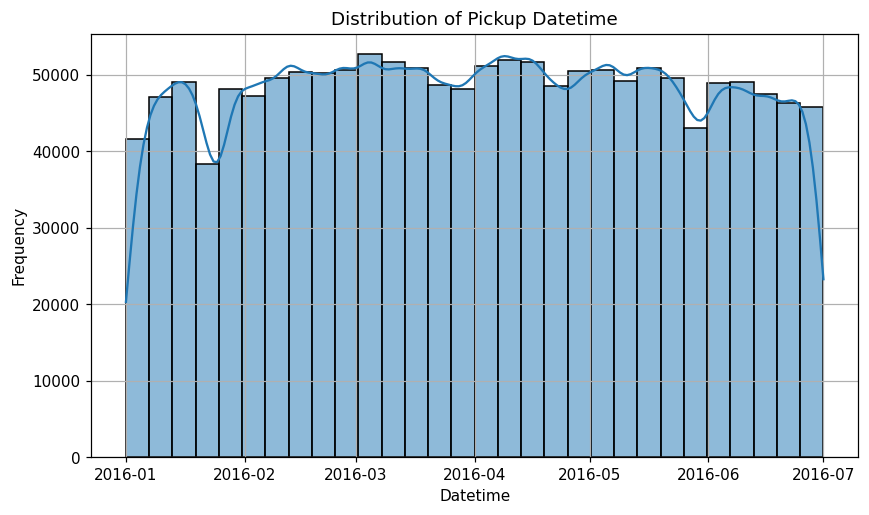

In [11]:
plt.figure(figsize=(9, 5), dpi=110)
sns.histplot(taxi_train_df["pickup_datetime"], bins=30, kde=True)
plt.title("Distribution of Pickup Datetime")
plt.xlabel("Datetime")
plt.ylabel("Frequency")
plt.grid()
plt.show()

It's difficult to see any trend with all the datetimes squeezed into one place. Let's visualize the count of rides over dates.

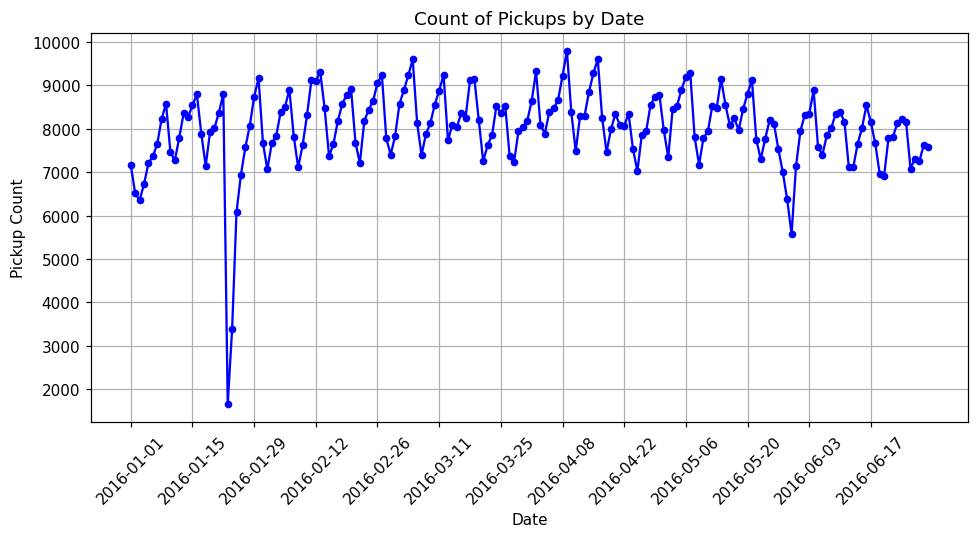

In [12]:
taxi_train_df["pickup_date"] = taxi_train_df["pickup_datetime"].dt.date

pickup_counts = taxi_train_df["pickup_date"].value_counts().sort_index()

plt.figure(figsize=(9, 5), dpi=110)
pickup_counts.plot(kind="line", marker="o", color="blue", linewidth=1.5, markersize=4)
plt.title("Count of Pickups by Date")
plt.xlabel("Date")
plt.ylabel("Pickup Count")

# Marking every 14th day on the x-axis
xticks = pickup_counts.index[::14]
plt.xticks(ticks=xticks, labels=[str(date) for date in xticks], rotation=45)

plt.tight_layout()
plt.grid(True)
plt.show()

We start to see a cyclic trend here. That has a cyclicity around 1-2 weeks. Using this information, we're now going to plot a weekly trend.

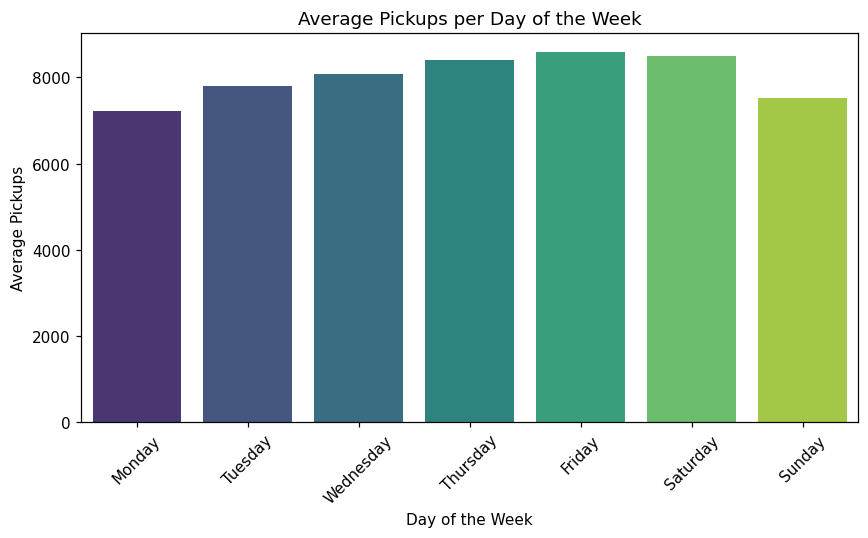

In [13]:
taxi_train_df["pickup_dayofweek"] = taxi_train_df["pickup_datetime"].dt.dayofweek
taxi_train_df["pickup_dayofweek"] = taxi_train_df["pickup_dayofweek"].map(
    lambda x: DAY_NAMES[x]
)
average_pickups_per_day = (
    taxi_train_df.groupby("pickup_dayofweek")["id"].nunique()
    / taxi_train_df.groupby("pickup_dayofweek")["pickup_date"].nunique()
)


plt.figure(figsize=(8, 5), dpi=110)
sns.barplot(
    x=average_pickups_per_day.index,
    y=average_pickups_per_day.values,
    order=DAY_NAMES,
    palette="viridis",
)
plt.title("Average Pickups per Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Pickups")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The above graph shows the average number of pickups per day per day of the week (Monday through Sunday).

We see a small rise on Friday and then a drop off during on Sundays. This might suggest increased cab usage over the start of the weekend, likely for leisure or travel purposes. Throughout the workweek, demand appears relatively stable, with the most significant decrease observed on Sundays and Mondays. Let's investigate if this pattern persists consistently across all months.

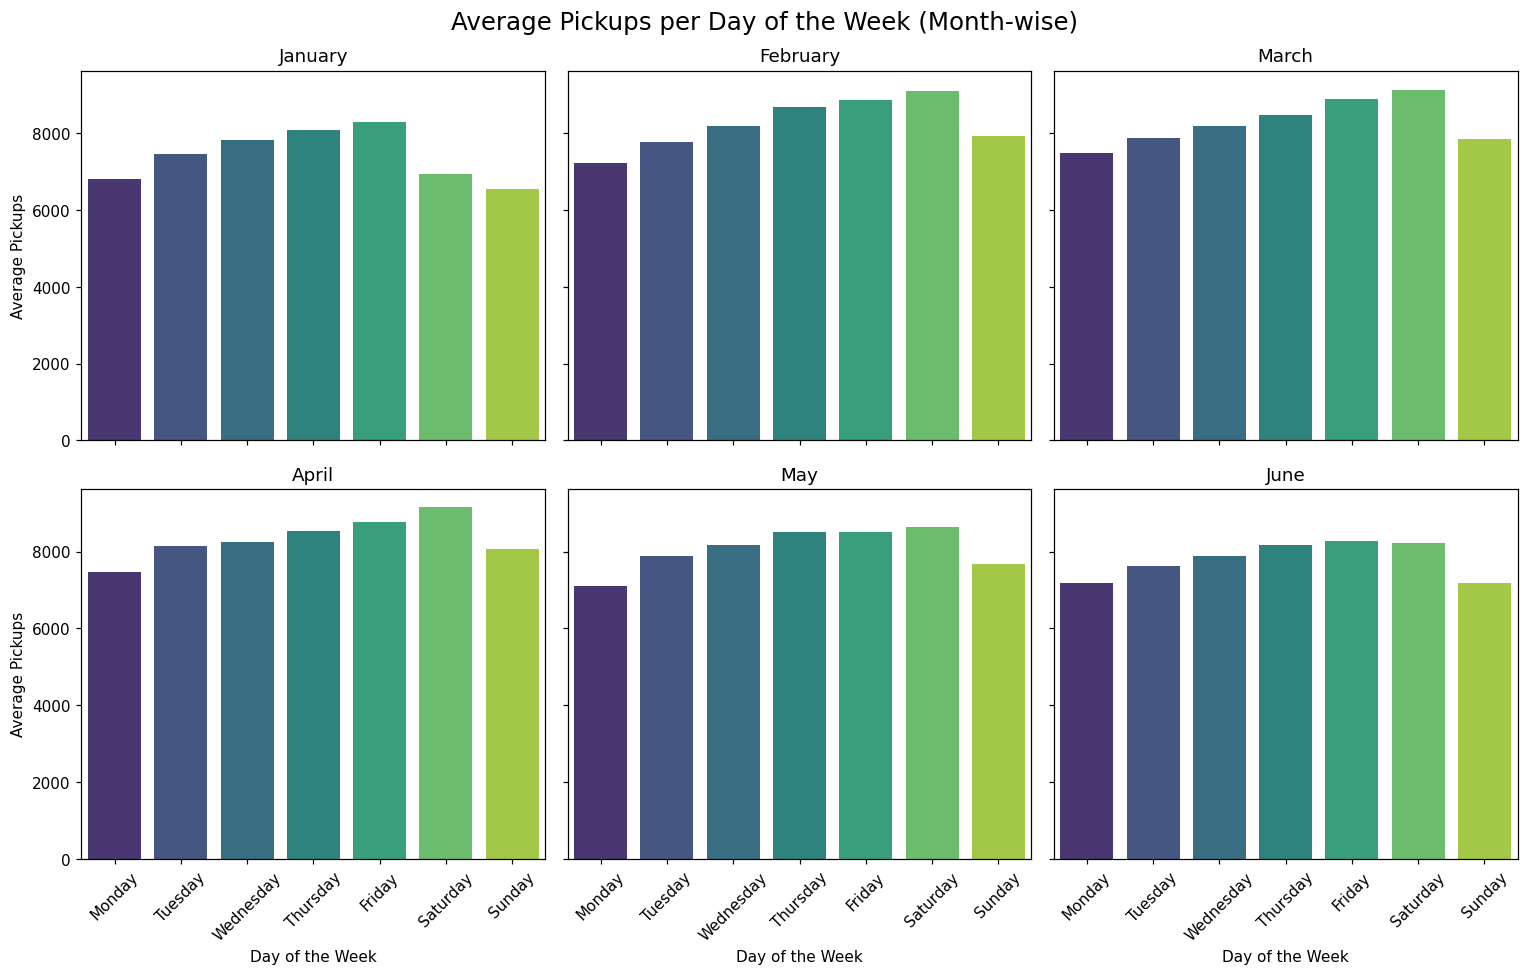

In [14]:
taxi_train_df["pickup_month"] = taxi_train_df["pickup_datetime"].dt.strftime("%m")
average_pickups_per_day = (
    (
        taxi_train_df.groupby(["pickup_month", "pickup_dayofweek"])["id"].nunique()
        / taxi_train_df.groupby(["pickup_month", "pickup_dayofweek"])[
            "pickup_date"
        ].nunique()
    )
    .reset_index()
    .rename(columns={0: "avg_pickups_per_day"})
)
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(14, 9), dpi=110, sharex=True, sharey=True
)

for i, month in enumerate(["01", "02", "03", "04", "05", "06"]):
    month_data = average_pickups_per_day[
        average_pickups_per_day["pickup_month"] == month
    ]
    ax = axes[i // 3, i % 3]
    sns.barplot(
        x=month_data["pickup_dayofweek"],
        y=month_data["avg_pickups_per_day"],
        order=DAY_NAMES,
        palette="viridis",
        ax=ax,
    )
    ax.set_title(f"{MONTH_NAMES[int(month)-1]}")
    ax.set_xlabel("Day of the Week")
    ax.set_ylabel("Average Pickups")
    ax.tick_params(axis="x", rotation=45)
fig.suptitle("Average Pickups per Day of the Week (Month-wise)", fontsize=16)
plt.tight_layout()
plt.show()

We see a different pattern here compared to the overall trend. February, March, April, and May share the same trend with their peaks on Saturdays. January sees a major drop off on Saturday and finally June shares a similar trend, but peaks on Friday instead.

Now we'll analyze the day-to-day trends throughout the months and juxtapose them with holidays to assess their potential impact on the number of pickups per day of the week.

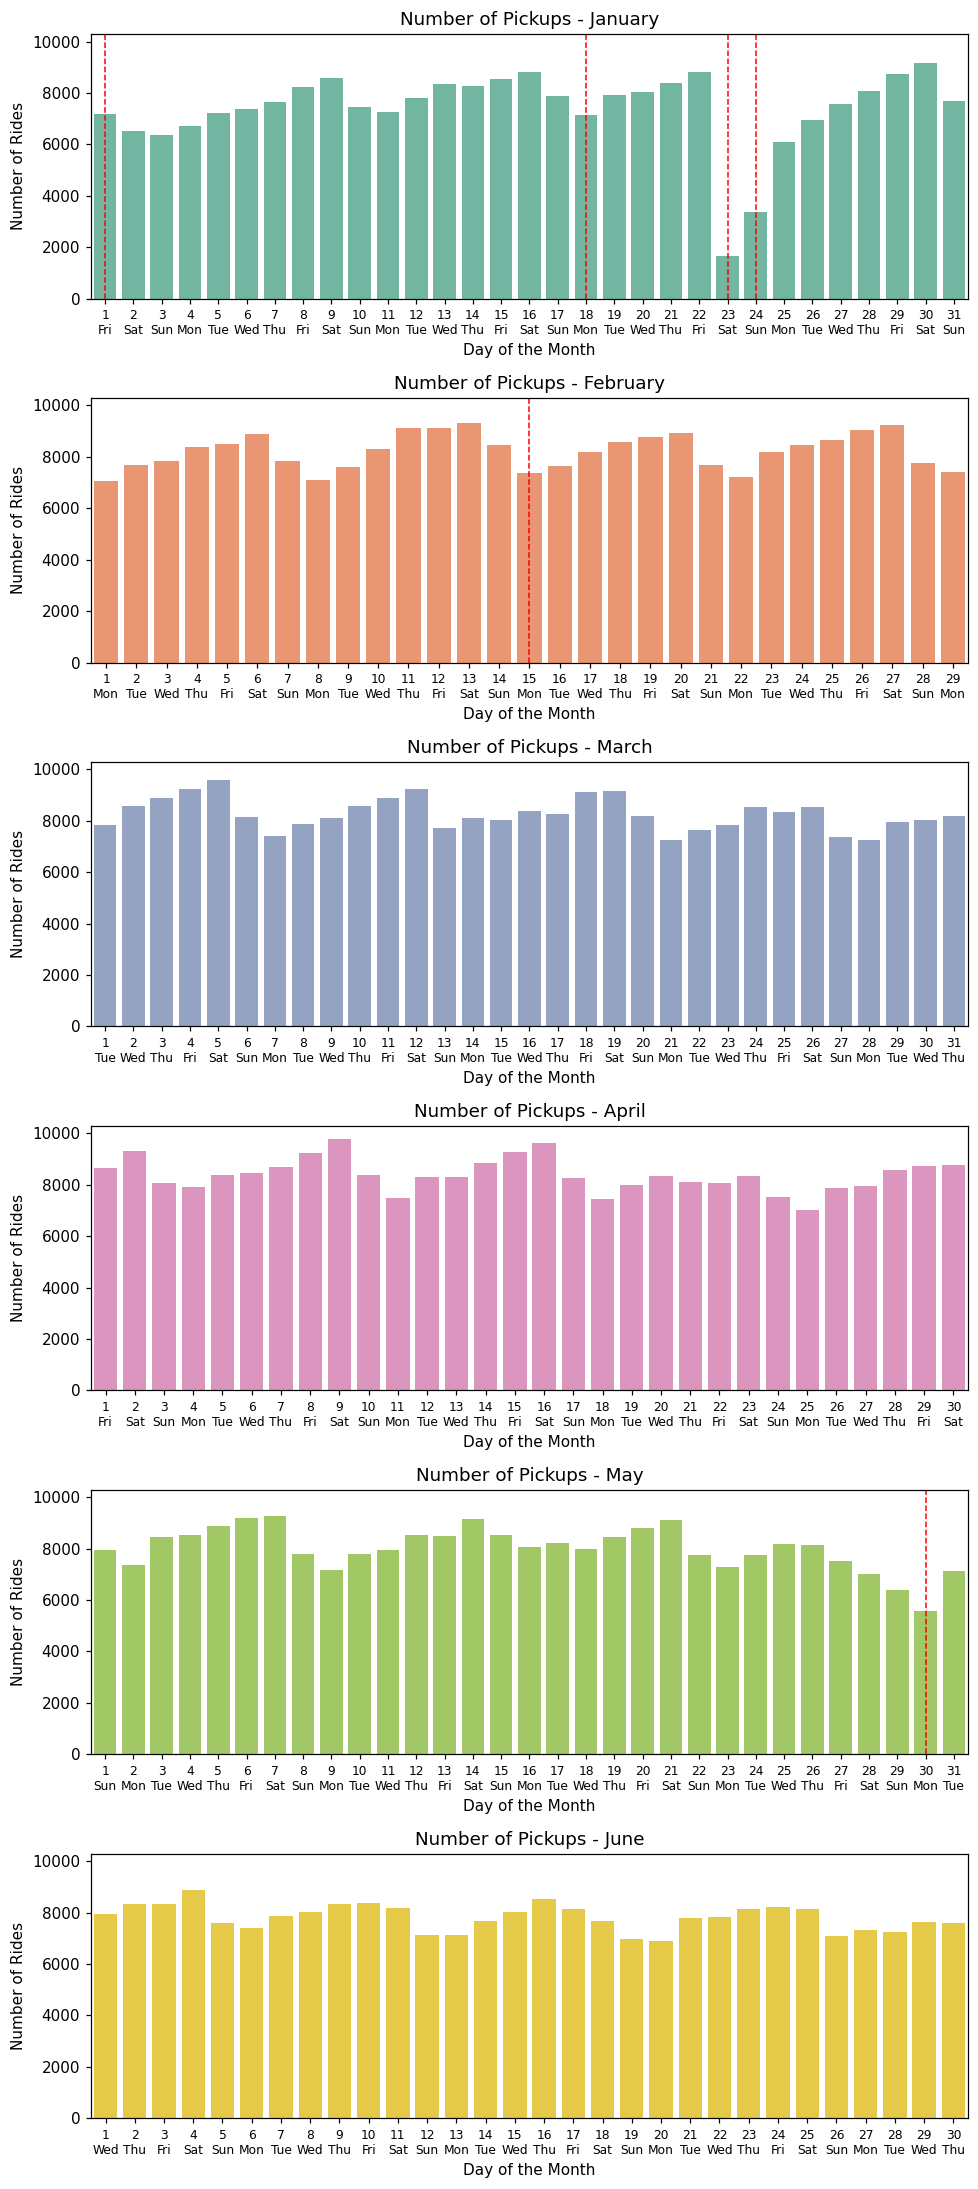

In [15]:
taxi_train_df["pickup_day"] = taxi_train_df["pickup_datetime"].dt.day
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(9, 20), dpi=110, sharey=True)
colors = sns.color_palette("Set2", n_colors=6)

for i, month in enumerate(["01", "02", "03", "04", "05", "06"]):
    month_data = taxi_train_df[taxi_train_df["pickup_month"] == month]
    ax = axes[i]

    sns.countplot(x="pickup_day", data=month_data, color=colors[i], ax=ax)
    ax.set_title(f"Number of Pickups - {MONTH_NAMES[int(month) - 1]}", fontsize=12)
    ax.set_xlabel("Day of the Month", fontsize=10)
    ax.set_ylabel("Number of Rides", fontsize=10)
    ax.tick_params(axis="x", labelsize=8)

    # Mark US holidays in the subplot
    for holiday, name in sorted(US_HOLIDAYS.items()):
        if holiday.month == int(month):
            ax.axvline(holiday.day - 1, color="red", linestyle="--", linewidth=1)

    # Update x-axis tick labels with day of the week
    day_labels = [item.get_text() for item in ax.get_xticklabels()]
    day_of_week = [
        dt.datetime.strptime(f"2016-{month}-{day}", "%Y-%m-%d").strftime("%a")
        for day in day_labels
    ]
    ax.set_xticklabels(
        [f"{label}\n{day}" for label, day in zip(day_labels, day_of_week)]
    )

plt.tight_layout()
plt.show()

What's interesting here is that all the months share the same trend, with peaks on Saturday. January is the only exception because on the 23rd and 24th NYC experienced a blizzard. Furthermore, holidays don't seem to make any impact to the cyclicity. 

However, let's remove the blizzard anomalies and look at the overall trend again.

In [16]:
taxi_train_wo_outliers_df = taxi_train_df.loc[
    ~taxi_train_df["pickup_date"].isin(US_HOLIDAYS.get_named("Blizzard"))
]

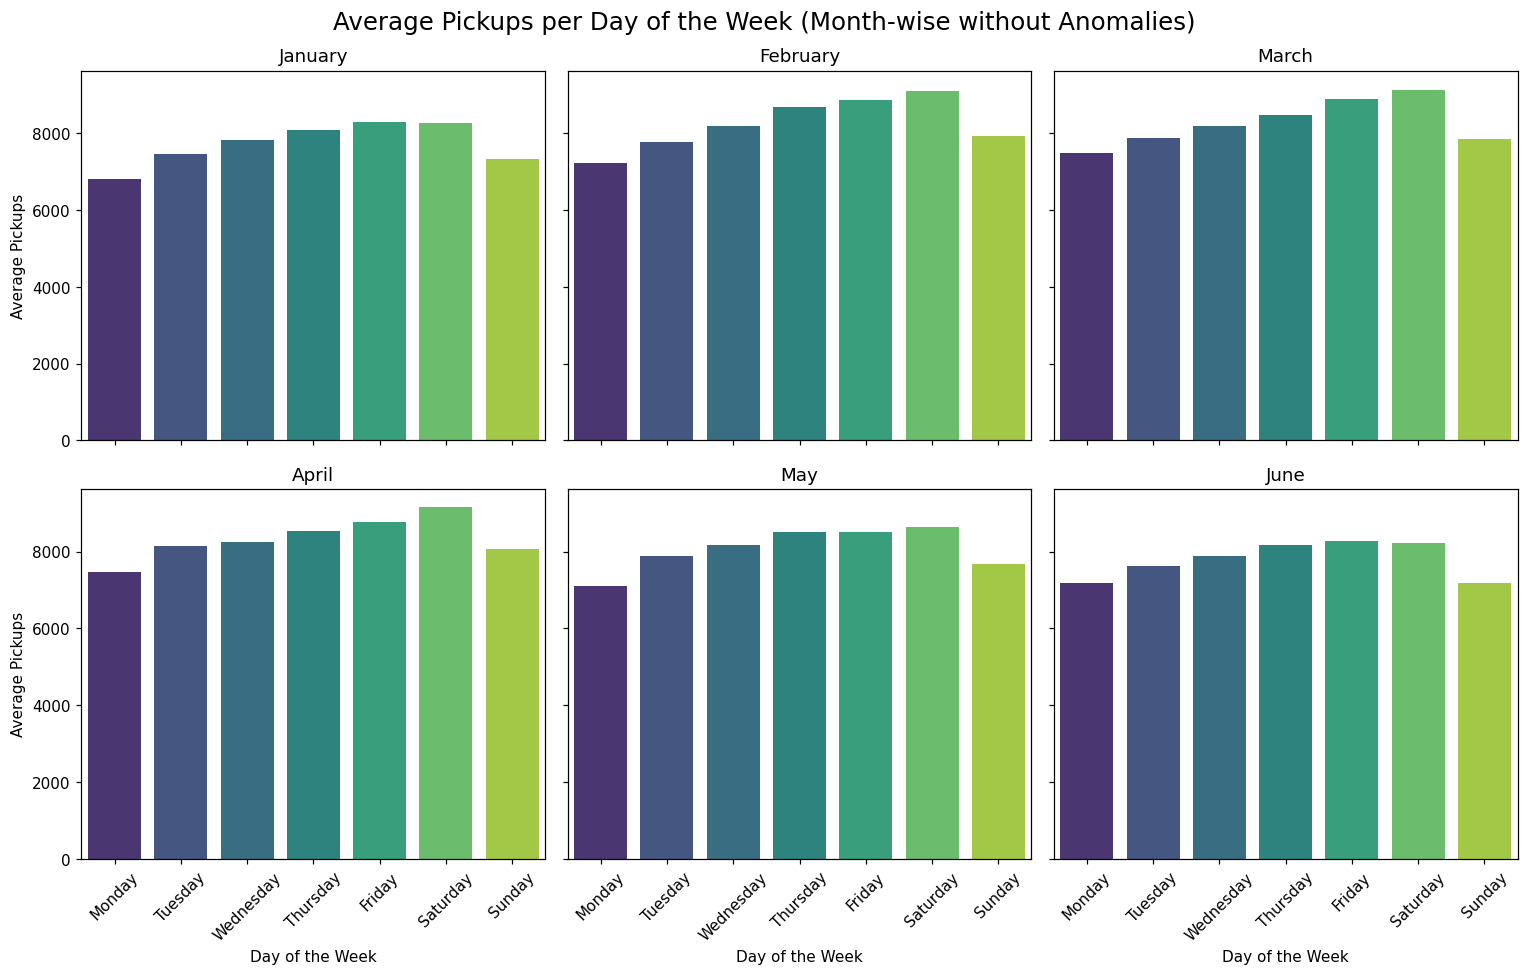

In [17]:
average_pickups_per_day = (
    (
        taxi_train_wo_outliers_df.groupby(["pickup_month", "pickup_dayofweek"])[
            "id"
        ].nunique()
        / taxi_train_wo_outliers_df.groupby(["pickup_month", "pickup_dayofweek"])[
            "pickup_date"
        ].nunique()
    )
    .reset_index()
    .rename(columns={0: "avg_pickups_per_day"})
)
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(14, 9), dpi=110, sharex=True, sharey=True
)

for i, month in enumerate(["01", "02", "03", "04", "05", "06"]):
    month_data = average_pickups_per_day[
        average_pickups_per_day["pickup_month"] == month
    ]
    ax = axes[i // 3, i % 3]
    sns.barplot(
        x=month_data["pickup_dayofweek"],
        y=month_data["avg_pickups_per_day"],
        order=DAY_NAMES,
        palette="viridis",
        ax=ax,
    )
    ax.set_title(f"{MONTH_NAMES[int(month)-1]}")
    ax.set_xlabel("Day of the Week")
    ax.set_ylabel("Average Pickups")
    ax.tick_params(axis="x", rotation=45)
fig.suptitle(
    "Average Pickups per Day of the Week (Month-wise without Anomalies)", fontsize=16
)
plt.tight_layout()
plt.show()

Now we see a consistent trend accross each month.

**Why did we do this?**
* Given that we don't have data for the entire year, we can't pass "month number" as an input to our model.
* This is because during inference, we might see out of distribution month numbers, i.e. 07-12.
* Using our analysis, we also know that January had two anomalies that skewed the cyclicity.
* Furthermore, we also know that certain days of the week observe more pickups on average than others.
* Finally, we also won't be passing "year number" due to the same reasons as above.

Now let's see if the day of the week and the time of the day share any relationship with the average number of pickups per day.

In [18]:
taxi_train_wo_outliers_df["pickup_hour"] = taxi_train_wo_outliers_df[
    "pickup_datetime"
].dt.hour
average_pickups_per_day = (
    (
        taxi_train_wo_outliers_df.groupby(["pickup_dayofweek", "pickup_hour"])[
            "id"
        ].nunique()
        / taxi_train_wo_outliers_df.groupby(["pickup_dayofweek", "pickup_hour"])[
            "pickup_date"
        ].nunique()
    )
    .reset_index()
    .rename(columns={0: "avg_pickups_per_day"})
)
grouped_min_max = average_pickups_per_day.groupby("pickup_dayofweek")[
    "avg_pickups_per_day"
].agg(["min", "max"])
average_pickups_per_day = average_pickups_per_day.merge(
    grouped_min_max, on="pickup_dayofweek"
)
average_pickups_per_day["normalized_avg_pickups"] = (
    average_pickups_per_day["avg_pickups_per_day"] - average_pickups_per_day["min"]
) / (average_pickups_per_day["max"] - average_pickups_per_day["min"])
average_pickups_per_day = average_pickups_per_day.drop(["min", "max"], axis=1)
average_pickups_per_day = (
    average_pickups_per_day.set_index("pickup_dayofweek").loc[DAY_NAMES].reset_index()
)

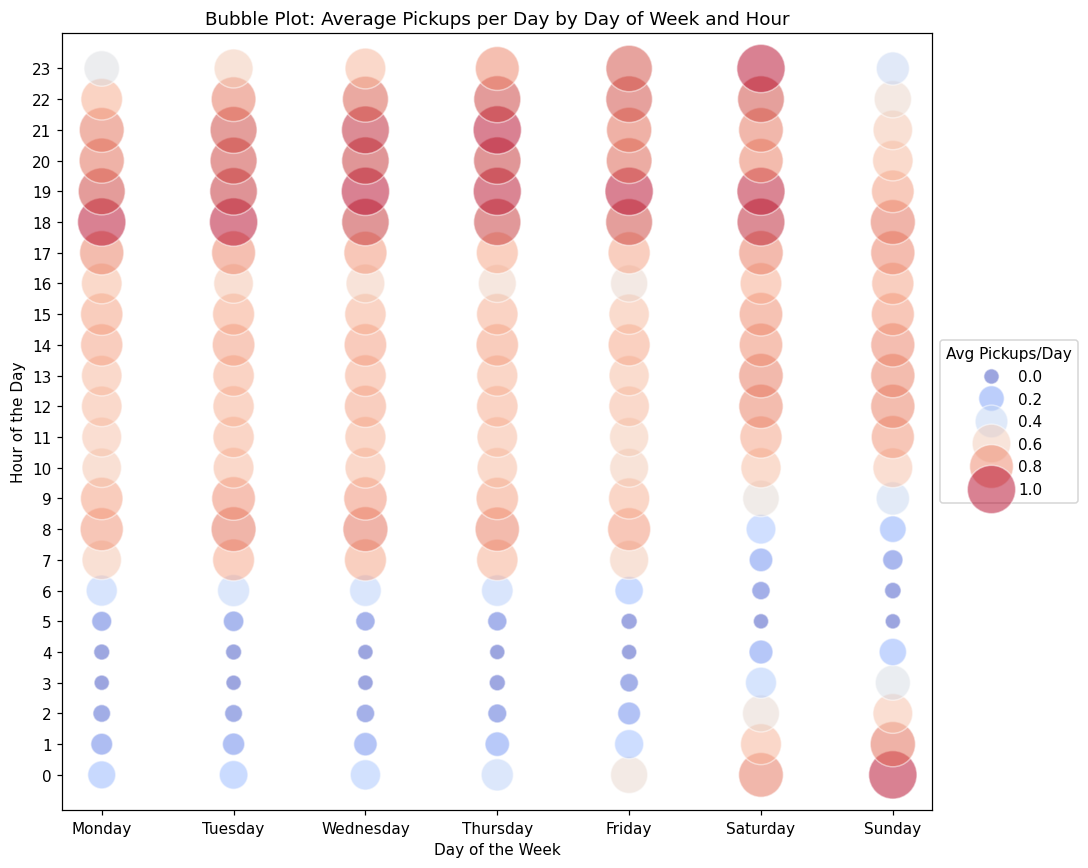

In [19]:
plt.figure(figsize=(10, 8), dpi=110)
scatter = sns.scatterplot(
    x=average_pickups_per_day["pickup_dayofweek"],
    y=average_pickups_per_day["pickup_hour"],
    size=average_pickups_per_day["normalized_avg_pickups"],
    sizes=(100, 1000),
    hue=average_pickups_per_day["normalized_avg_pickups"],
    palette="coolwarm",
    alpha=0.5,
)
plt.xlabel("Day of the Week")
plt.ylabel("Hour of the Day")
plt.title("Bubble Plot: Average Pickups per Day by Day of Week and Hour")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Avg Pickups/Day")
plt.yticks(range(24))
plt.tight_layout()
plt.show()

* From the above the above graph, most of the pickups on the weekdays happen during the hours of 6 PM to 10 PM.
* Saturday and Sunday sees a few late night rides -- these could be patrons traveling around past midnight on Friday and Saturdays.
* Sunday night sees fewer rides, perhaps because people are trying to get to work the next day.
* Let's try segregating these rides into buckets and then seeing the distribution:

In [20]:
taxi_train_wo_outliers_df["pickup_timeofday"] = pd.cut(
    taxi_train_wo_outliers_df["pickup_hour"],
    bins=HOURLY_BIN_EDGES,
    labels=HOURLY_BUCKETS,
    right=False,
)
average_pickups_per_day = (
    (
        taxi_train_wo_outliers_df.groupby(["pickup_dayofweek", "pickup_timeofday"])[
            "id"
        ].nunique()
        / taxi_train_wo_outliers_df.groupby(["pickup_dayofweek", "pickup_timeofday"])[
            "pickup_date"
        ].nunique()
    )
    .reset_index()
    .rename(columns={0: "avg_pickups_per_day"})
)
grouped_min_max = average_pickups_per_day.groupby("pickup_dayofweek")[
    "avg_pickups_per_day"
].agg(["min", "max"])
average_pickups_per_day = average_pickups_per_day.merge(
    grouped_min_max, on="pickup_dayofweek"
)
average_pickups_per_day["normalized_avg_pickups"] = (
    average_pickups_per_day["avg_pickups_per_day"] - average_pickups_per_day["min"]
) / (average_pickups_per_day["max"] - average_pickups_per_day["min"])
average_pickups_per_day = average_pickups_per_day.drop(["min", "max"], axis=1)
average_pickups_per_day = (
    average_pickups_per_day.set_index("pickup_timeofday")
    .loc[HOURLY_BUCKETS]
    .reset_index()
)
average_pickups_per_day = (
    average_pickups_per_day.set_index("pickup_dayofweek").loc[DAY_NAMES].reset_index()
)

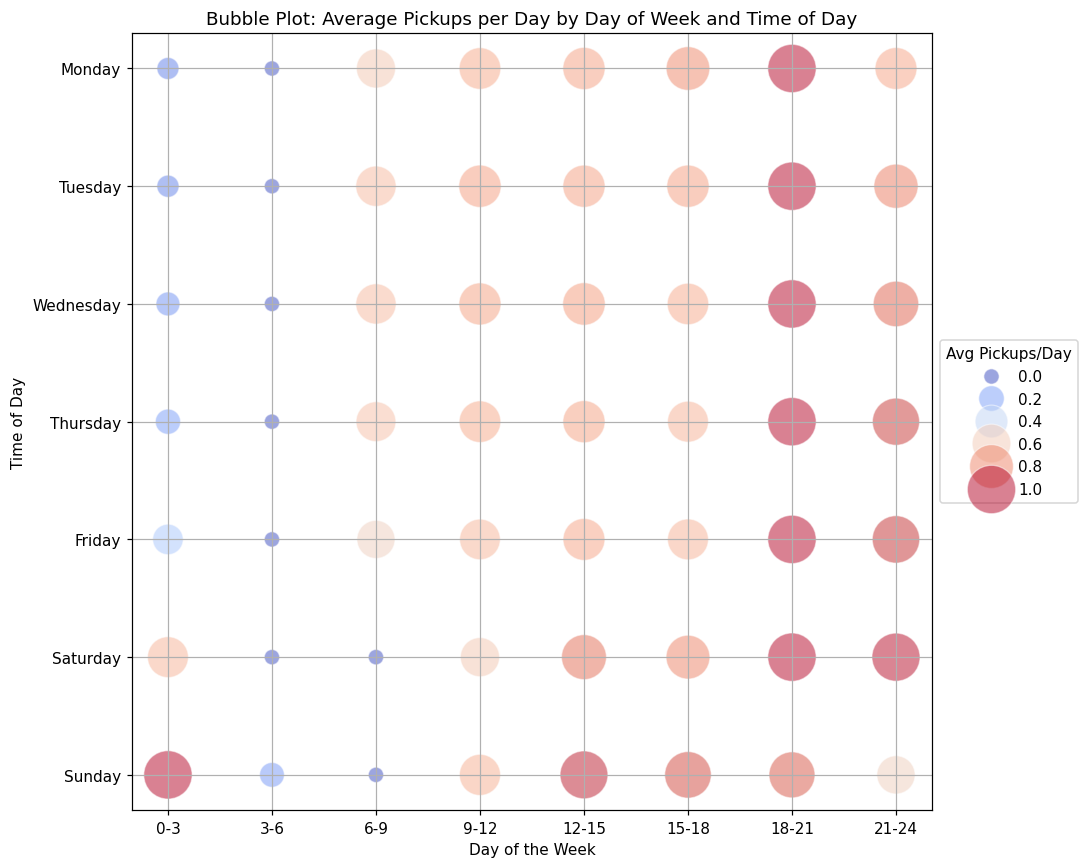

In [21]:
plt.figure(figsize=(10, 8), dpi=110)
scatter = sns.scatterplot(
    y=average_pickups_per_day["pickup_dayofweek"],
    x=average_pickups_per_day["pickup_timeofday"],
    size=average_pickups_per_day["normalized_avg_pickups"],
    sizes=(100, 1000),
    hue=average_pickups_per_day["normalized_avg_pickups"],
    palette="coolwarm",
    alpha=0.5,
)
plt.xlabel("Day of the Week")
plt.ylabel("Time of Day")
plt.title("Bubble Plot: Average Pickups per Day by Day of Week and Time of Day")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Avg Pickups/Day")
plt.grid(True)
plt.tight_layout()
plt.show()

The same trend is more apparent when we use bucketized times as opposed to the digits themselves.

### Passenger Count

Let's look at the distribution of passenger counts and rides:

In [22]:
taxi_train_wo_outliers_df["passenger_count"] = taxi_train_wo_outliers_df[
    "passenger_count"
].astype(int)

In [24]:
passenger_count_counts = (
    taxi_train_wo_outliers_df["passenger_count"].value_counts().reset_index()
).sort_values(by=["passenger_count"])

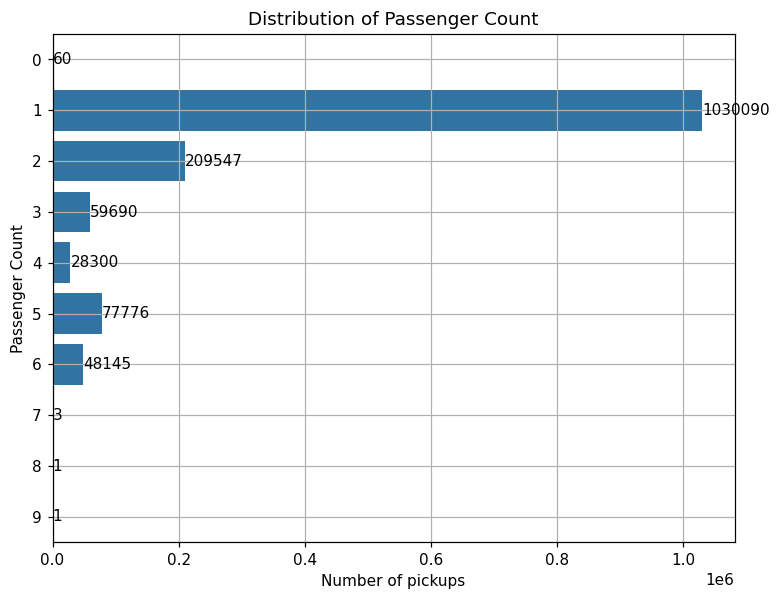

In [25]:
plt.figure(figsize=(8, 6), dpi=110)
barplot = sns.barplot(
    data=passenger_count_counts, y="passenger_count", x="count", orient="h"
)
plt.title("Distribution of Passenger Count")
plt.xlabel("Number of pickups")
plt.ylabel("Passenger Count")

for index, value in enumerate(passenger_count_counts["count"]):
    barplot.text(value, index, str(value), ha="left", va="center")
plt.grid()
plt.show()

* From the looks of it, there are rides with 0 passengers; which seems odd. 
* Furthermore, there's a high skew towards 1 passenger and very few cabs with 7+ passengers.
* Not to mention, the number of passengers shouldn't really impact the travel time:
    - unless the number of passengers correlates with the size of the car
    - larger cars tend to move slower through traffic
* Since this is a driver entered number, we can assume that the default value is probably 1.
* 0 might signify those trips that a driver might be taking back home.
* Not to mention, it might be highly unreliable as it excepts a manual input from a driver with no value for them whatsoever.
* Due to the imbalance and lack of sanity, we can choose to ignore this value in our analysis; after we verify whether it shares any correlation with other variables in the dataset.

### Vendor ID

In [26]:
taxi_train_wo_outliers_df["vendor_id"].value_counts(normalize=True)

vendor_id
2    0.534743
1    0.465257
Name: proportion, dtype: float64

Vendor IDs seemed to be almost equally split among pickups. This ideally also shouldn't have an impact on the travel duration, unless one vendor tends to operate more often during different times of the day.

### Latitude & Longtitude (Distances)


Rather than passing both the pickup and drop off latitude and longtitudes as a numerical value, we're going to calculate three different types of distances and store them for later analyses:

1. Euclidean Distance - the conventional straight line distance
2. Haversine Distance - calculates the distance between two points on the Earth (a sphere)
3. OSRM (Open Source Routing Machine) Distance - using a free and open source API to fetch distances

In [27]:
def haversine_distance(lat1, lon1, lat2, lon2):
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geodesic(coords_1, coords_2).kilometers


def euclidean_distance(lat1, lon1, lat2, lon2):
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    return euclidean(point1, point2)

In [28]:
taxi_train_wo_outliers_df["distance_euclidean"] = taxi_train_wo_outliers_df.apply(
    lambda x: euclidean_distance(
        x["pickup_latitude"],
        x["pickup_longitude"],
        x["dropoff_latitude"],
        x["dropoff_longitude"],
    ),
    axis=1,
)

taxi_train_wo_outliers_df["distance_haversine"] = taxi_train_wo_outliers_df.apply(
    lambda x: haversine_distance(
        x["pickup_latitude"],
        x["pickup_longitude"],
        x["dropoff_latitude"],
        x["dropoff_longitude"],
    ),
    axis=1,
)

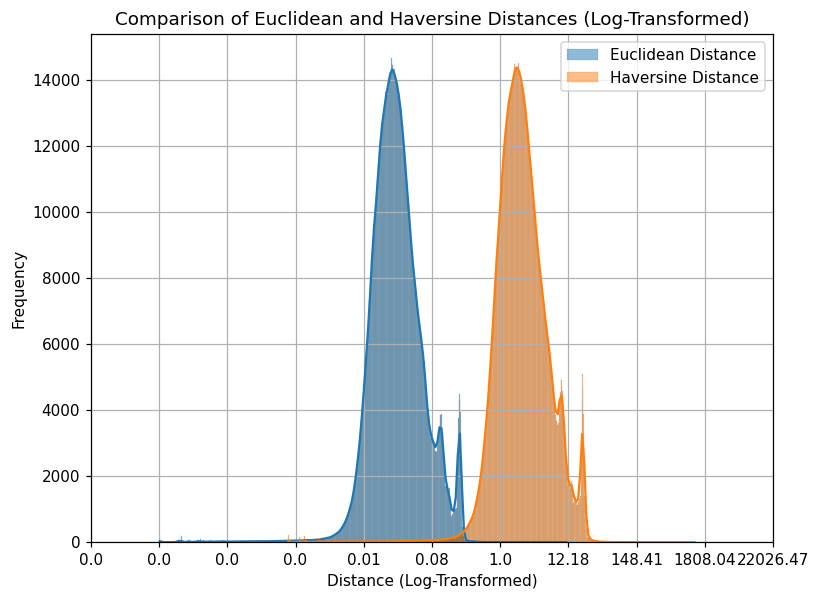

In [29]:
plt.figure(figsize=(8, 6), dpi=110)
taxi_train_wo_outliers_df["log_distance_euclidean"] = np.log(
    taxi_train_wo_outliers_df["distance_euclidean"]
)
taxi_train_wo_outliers_df["log_distance_haversine"] = np.log(
    taxi_train_wo_outliers_df["distance_haversine"]
)

sns.histplot(
    taxi_train_wo_outliers_df["log_distance_euclidean"],
    label="Euclidean Distance",
    kde=True,
)
sns.histplot(
    taxi_train_wo_outliers_df["log_distance_haversine"],
    label="Haversine Distance",
    kde=True,
)
plt.xlabel("Distance (Log-Transformed)")
plt.ylabel("Frequency")
plt.title("Comparison of Euclidean and Haversine Distances (Log-Transformed)")
plt.legend()
ticks, _ = plt.xticks()
tick_labels = [round(np.exp(x), 2) for x in ticks]
plt.xticks(ticks, tick_labels)
plt.grid()
plt.show()

Haversine distance looks like a much better measure as the euclidean distance seems to be giving very small numbers. Lastly, haversine is more reliable for great-circle distances.

In [30]:
sample_point = taxi_train_wo_outliers_df[
    taxi_train_wo_outliers_df["id"] == "id0548515"
].iloc[0]
pickup_lat = sample_point["pickup_latitude"]
pickup_lon = sample_point["pickup_longitude"]
dropoff_lat = sample_point["dropoff_latitude"]
dropoff_lon = sample_point["dropoff_longitude"]
haversine_distance = sample_point["distance_haversine"]
euclidean_distance = sample_point["distance_euclidean"]

pickup_coords = (pickup_lat, pickup_lon)
dropoff_coords = (dropoff_lat, dropoff_lon)

map_center = [(pickup_lat + dropoff_lat) / 2, (pickup_lon + dropoff_lon) / 2]

In [31]:
m = folium.Map(
    location=map_center,
    zoom_start=15,
    tiles="https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}",
    attr="Google",
)
folium.Marker(
    [pickup_lat, pickup_lon], popup="Pickup", icon=folium.Icon(color="red")
).add_to(m)
folium.Marker(
    [dropoff_lat, dropoff_lon], popup="Dropoff", icon=folium.Icon(color="green")
).add_to(m)
folium.PolyLine(
    [(pickup_lat, pickup_lon), (dropoff_lat, dropoff_lon)],
    color="blue",
    weight=2.5,
    opacity=1,
    dash_array="5, 5",
    popup=f"Haversine Distance: {haversine_distance:.2f} km\nEuclidean Distance: {euclidean_distance:.2f} km",
).add_to(m)
m

The image looks as follows if it doesn't render for you:

<img src="images/eg_euclidean_vs_haversine.png" alt="Euclidean vs. Haversine" width="650">

* It is clear from the image that even haversine would fail to detect the distance in this case.
* Given the body of water in the center, a cab would have to travel around or take the bridge.
* This is where OSRM's Free and Open Sourced API would help us fetch distances.

In [32]:
def osrm_distance(lat1, lon1, lat2, lon2, max_retries=3):
    url = f"http://127.0.0.1:5000/route/v1/driving/{lon1},{lat1};{lon2},{lat2}?overview=false"

    # Configure retries
    retries = Retry(
        total=max_retries, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504]
    )

    # Create a session with retry settings
    session = requests.Session()
    adapter = HTTPAdapter(max_retries=retries)
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    for attempt in range(max_retries + 1):
        try:
            response = session.get(url)
            response.raise_for_status()

            if response.status_code == 200:
                distance = response.json()["routes"][0]["distance"] / 1000
                return distance
            else:
                print(f"Error: {response.status_code}")
                return None

        except requests.exceptions.RequestException as e:
            print(f"Request failed on attempt {attempt + 1}/{max_retries + 1}: {e}")

    print(f"Maximum number of retries reached. Unable to complete the request.")
    return None

In [33]:
# these were calculated previously using a local OSRM instance
precalculated_osrm_distances_df = pd.read_csv("data/train_osrm_distances.csv")

In [34]:
def calculate_osrm_distance(id_, lat1, lon1, lat2, lon2, dist):
    if np.isnan(dist):
        distance = osrm_distance(lat1, lon1, lat2, lon2)
        return distance
    else:
        return dist

**NOTE**: Do not run the following piece of code; it won't run unless you host a OSRM service.

In [35]:
taxi_train_wo_outliers_df = pd.merge(
    taxi_train_wo_outliers_df,
    precalculated_osrm_distances_df[["id", "distance_osrm"]],
    on="id",
    how="left",
)

In [36]:
taxi_train_wo_outliers_df["distance_osrm"] = taxi_train_wo_outliers_df.apply(
    lambda x: calculate_osrm_distance(
        x["id"],
        x["pickup_latitude"],
        x["pickup_longitude"],
        x["dropoff_latitude"],
        x["dropoff_longitude"],
        x["distance_osrm"]
    ),
    axis=1,
)

Request failed on attempt 1/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-74.04054260253906,40.71708679199219;-74.04055023193358,40.717090606689446?overview=false
Request failed on attempt 2/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-74.04054260253906,40.71708679199219;-74.04055023193358,40.717090606689446?overview=false
Request failed on attempt 3/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-74.04054260253906,40.71708679199219;-74.04055023193358,40.717090606689446?overview=false
Request failed on attempt 4/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-74.04054260253906,40.71708679199219;-74.04055023193358,40.717090606689446?overview=false
Maximum number of retries reached. Unable to complete the request.
Request failed on attempt 1/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-74.00809478759764,40.725883

Request failed on attempt 1/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-73.993896484375,40.75139617919922;-73.99386596679686,40.75139617919922?overview=false
Request failed on attempt 2/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-73.993896484375,40.75139617919922;-73.99386596679686,40.75139617919922?overview=false
Request failed on attempt 3/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-73.993896484375,40.75139617919922;-73.99386596679686,40.75139617919922?overview=false
Request failed on attempt 4/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-73.993896484375,40.75139617919922;-73.99386596679686,40.75139617919922?overview=false
Maximum number of retries reached. Unable to complete the request.
Request failed on attempt 1/4: 400 Client Error: Bad Request for url: http://127.0.0.1:5000/route/v1/driving/-74.0278091430664,40.753456115722656;-74

Now let's compare OSRM's results with haversine:

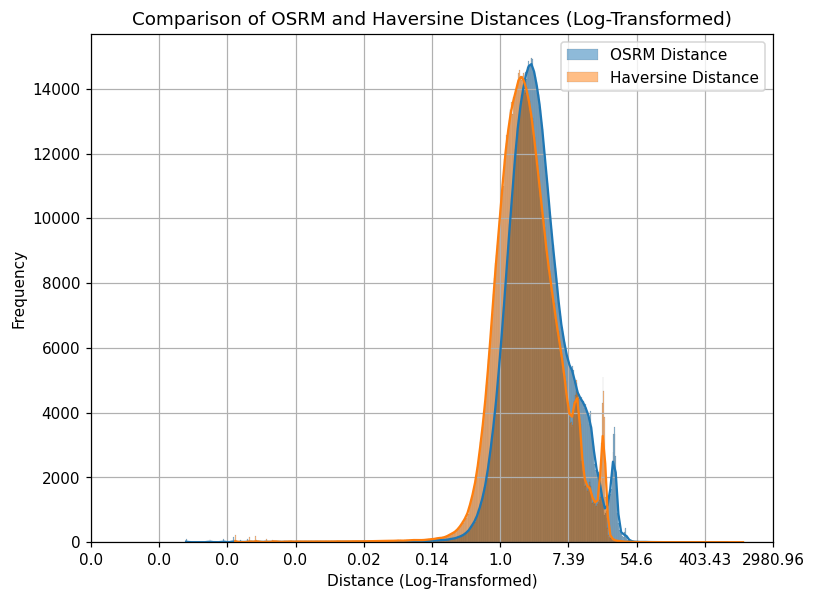

In [37]:
plt.figure(figsize=(8, 6), dpi=110)
taxi_train_wo_outliers_df["log_distance_osrm"] = np.log(
    taxi_train_wo_outliers_df["distance_osrm"]
)
taxi_train_wo_outliers_df["log_distance_haversine"] = np.log(
    taxi_train_wo_outliers_df["distance_haversine"]
)

sns.histplot(
    taxi_train_wo_outliers_df["log_distance_osrm"],
    label="OSRM Distance",
    kde=True,
)
sns.histplot(
    taxi_train_wo_outliers_df["log_distance_haversine"],
    label="Haversine Distance",
    kde=True,
)
plt.xlabel("Distance (Log-Transformed)")
plt.ylabel("Frequency")
plt.title("Comparison of OSRM and Haversine Distances (Log-Transformed)")
plt.legend()
ticks, _ = plt.xticks()
tick_labels = [round(np.exp(x), 2) for x in ticks]
plt.xticks(ticks, tick_labels)
plt.grid()
plt.show()

* Even though the differences don't look major on the graphs, OSRM tends to predict higher distances than Haversine.
* This is because the driving distance between two points isn't usually a straight line.
* Furthermore, wherever haversine failed to capture distances, we'll resort to using haversine as a backup.

Looking back at the previous example, we can see how the OSRM distance has improved the prediction:

In [38]:
osrm_sample_point = taxi_train_wo_outliers_df[
    taxi_train_wo_outliers_df["id"] == sample_point["id"]
].iloc[0]
pickup_lat = osrm_sample_point["pickup_latitude"]
pickup_lon = osrm_sample_point["pickup_longitude"]
dropoff_lat = osrm_sample_point["dropoff_latitude"]
dropoff_lon = osrm_sample_point["dropoff_longitude"]
haversine_distance = osrm_sample_point["distance_haversine"]
osrm_distance = osrm_sample_point["distance_osrm"]

In [39]:
def osrm_route(lat1, lon1, lat2, lon2, max_retries=3):
    url = (
        f"http://127.0.0.1:5000/route/v1/driving/{lon1},{lat1};{lon2},{lat2}?steps=true"
    )

    # Configure retries
    retries = Retry(
        total=max_retries, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504]
    )

    # Create a session with retry settings
    session = requests.Session()
    adapter = HTTPAdapter(max_retries=retries)
    session.mount("http://", adapter)
    session.mount("https://", adapter)

    for attempt in range(max_retries + 1):
        try:
            response = session.get(url)
            response.raise_for_status()

            if response.status_code == 200:
                route_info = response.json()["routes"][0]
                return route_info
            else:
                print(f"Error: {response.status_code}")
                return None

        except requests.exceptions.RequestException as e:
            print(f"Request failed on attempt {attempt + 1}/{max_retries + 1}: {e}")

    print(f"Maximum number of retries reached. Unable to complete the request.")
    return None

In [40]:
route_geometry = osrm_route(
    pickup_lat,
    pickup_lon,
    dropoff_lat,
    dropoff_lon,
).get("geometry")

decoded_route = polyline.decode(route_geometry)
shapely_route = LineString(decoded_route)
route_coords = list(shapely_route.coords)

In [41]:
m = folium.Map(
    location=map_center,
    zoom_start=14,
    tiles="https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}",
    attr="Google",
)
folium.Marker(
    [pickup_lat, pickup_lon], popup="Pickup", icon=folium.Icon(color="red")
).add_to(m)
folium.Marker(
    [dropoff_lat, dropoff_lon], popup="Dropoff", icon=folium.Icon(color="green")
).add_to(m)
folium.PolyLine(
    [(pickup_lat, pickup_lon), (dropoff_lat, dropoff_lon)],
    color="blue",
    weight=2.5,
    opacity=1,
    dash_array="5, 5",
    popup=f"Haversine Distance: {haversine_distance:.2f} km",
).add_to(m)
folium.PolyLine(
    route_coords,
    color="orange",
    weight=4,
    opacity=1,
    dash_array="5, 5",
    popup=f"OSRM Distance: {osrm_distance:.2f} km",
).add_to(m)
m

The image looks as follows if it doesn't render for you:

<img src="images/eg_osrm_vs_haversine.png" alt="Euclidean vs. Haversine" width="650">

As shown in the image above, the OSRM algorithm does a far better job of routing the distance compared to haversine.

### Store and Forward Flag

This indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

This ideally should have no impact on the trip duration (unless a certain lag impacts the way trip duration is calculated).

In [42]:
taxi_train_wo_outliers_df["store_and_fwd_flag"].value_counts(normalize=True)

store_and_fwd_flag
N    0.994479
Y    0.005521
Name: proportion, dtype: float64

There is a huge imbalance here, with a majority of the variables belong to the `N` category.

### Trip Duration

This is our dependent variable.

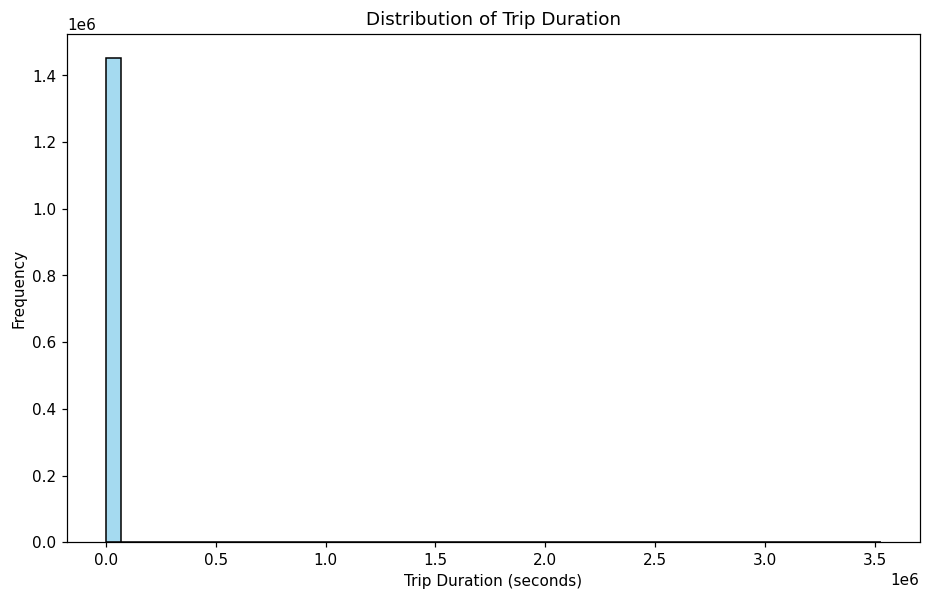

In [43]:
plt.figure(figsize=(10, 6), dpi=110)
sns.histplot(
    taxi_train_wo_outliers_df["trip_duration"], kde=False, bins=50, color="skyblue"
)
plt.title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

From the above histogram, we can see the data is very skewed with most trips taking a short amount of time. Let's take the log of this and visualize it differently.

In [44]:
taxi_train_wo_outliers_df["log_trip_duration"] = np.log(
    taxi_train_wo_outliers_df["trip_duration"]
)

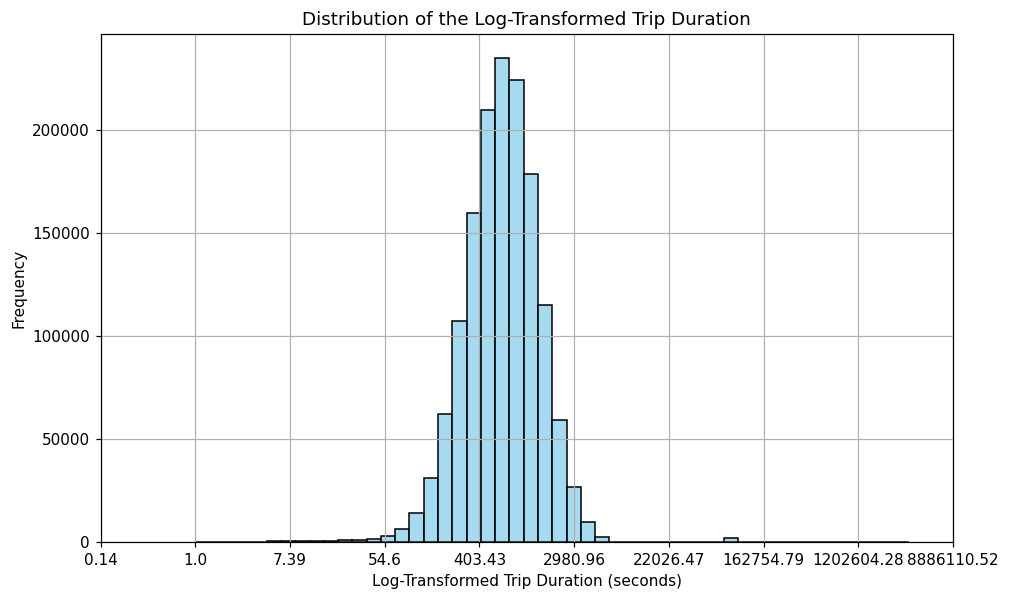

In [45]:
plt.figure(figsize=(10, 6), dpi=110)
sns.histplot(
    taxi_train_wo_outliers_df["log_trip_duration"], kde=False, bins=50, color="skyblue"
)
plt.title("Distribution of the Log-Transformed Trip Duration")
plt.xlabel("Log-Transformed Trip Duration (seconds)")
plt.ylabel("Frequency")
ticks, _ = plt.xticks()
tick_labels = [round(np.exp(x), 2) for x in ticks]
plt.xticks(ticks, tick_labels)
plt.grid()
plt.show()

* Most of the trips seem to take around 60-3000 seconds which is between a minute to an hour.
* Going forward for the bivariate analysis, we might have to plot the log of trip durations if we want to visualize them.

## Bivariate Analysis

Before we proceed with the analysis, we should keep in mind that the variable we're trying to predict is `trip_duration`. Travel time is primarily a function of the following:

* vehicle speed: characteristics of vehicle (but should have a maximum speed they abide by)
* traffic: affected by the time of day
* distance:
    - straight line distance OR
    - shortest distance to final destination
    
### Pick up Time vs Trip Duration

So far, we know we can use the following attributes of date:
1. Day of the week
2. Time of Day

Let's see how each of these compare to the distribution of trip duration.

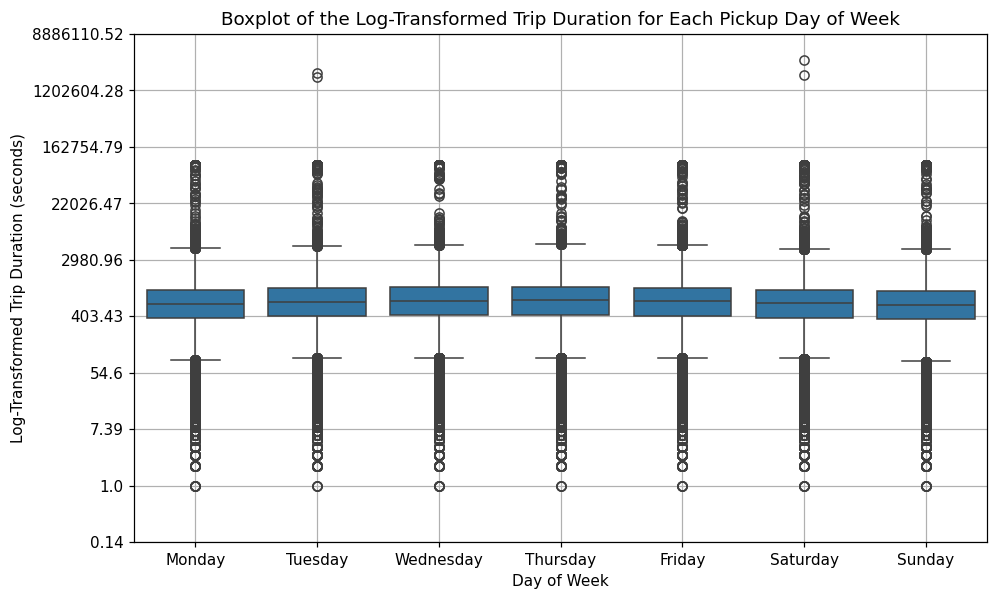

In [46]:
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(
    x="pickup_dayofweek",
    y="log_trip_duration",
    data=taxi_train_wo_outliers_df,
    order=DAY_NAMES,
)
plt.title("Boxplot of the Log-Transformed Trip Duration for Each Pickup Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Log-Transformed Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.grid()
plt.show()

It's very hard to see a pattern here, so let's compare the 5 point summary of each of the day of the week in a tabular format:

In [47]:
taxi_train_wo_outliers_df.groupby(["pickup_dayofweek"])["trip_duration"].describe().loc[
    DAY_NAMES
]

,count,mean,std,min,25%,50%,75%,max
pickup_dayofweek,,,,,,,,
Monday,187418.0,897.947839,2769.429213,1.0,380.0,630.0,1027.0,86392.0
Tuesday,202749.0,983.463124,7235.007591,1.0,407.0,679.0,1102.0,2227612.0
Wednesday,210136.0,975.450494,2903.805145,1.0,416.0,694.0,1133.0,86366.0
Thursday,218574.0,1006.528654,3100.383654,1.0,420.0,709.0,1155.0,86387.0
Friday,223533.0,990.224200,3274.974477,1.0,410.0,686.0,1112.0,86390.0
Saturday,219220.0,947.461057,9389.188017,1.0,385.0,636.0,1012.0,3526282.0
Sunday,191983.0,901.629702,3452.036079,1.0,363.0,602.0,979.0,86369.0


* Similar to the average number of pickups per day, we're seeing a cyclic pattern.
* Except here the peak of mean/median `trip_duration` happens on Thursday and then slowly falls off on Saturday.

Let's check this trend out for time of day:

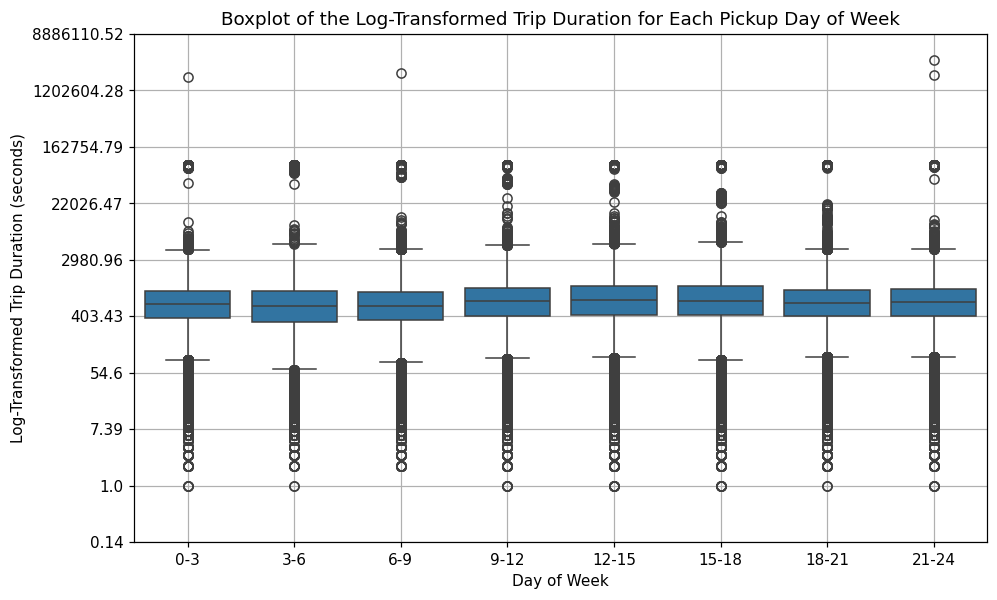

In [48]:
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(
    x="pickup_timeofday",
    y="log_trip_duration",
    data=taxi_train_wo_outliers_df,
    order=HOURLY_BUCKETS,
)
plt.title("Boxplot of the Log-Transformed Trip Duration for Each Pickup Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Log-Transformed Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.grid()
plt.show()

In [49]:
taxi_train_wo_outliers_df.groupby(["pickup_timeofday"])["trip_duration"].describe().loc[
    HOURLY_BUCKETS
]

,count,mean,std,min,25%,50%,75%,max
pickup_timeofday,,,,,,,,
0-3,118869.0,914.106193,6666.996975,1.0,375.0,622.0,995.0,1939736.0
3-6,51400.0,880.087023,3712.106556,1.0,326.0,577.0,987.0,86377.0
6-9,155738.0,864.449640,6210.890479,2.0,353.0,585.0,965.0,2227612.0
9-12,201093.0,944.969909,2777.712109,1.0,410.0,688.0,1119.0,86367.0
12-15,216855.0,1034.431966,3302.143108,1.0,426.0,715.0,1169.0,86391.0
15-18,211769.0,1076.259500,3274.347308,1.0,416.0,706.0,1185.0,86387.0
18-21,264064.0,919.093402,3117.452143,1.0,401.0,657.0,1038.0,86369.0
21-24,233825.0,946.538266,9056.312355,1.0,404.0,659.0,1048.0,3526282.0


* The peak here happens at around 15-18 and then the mean and median travel duration slowly tapers off.
* Let's observe this trend for with a combination of both variables:

In [50]:
median_trip_duration = (
    taxi_train_wo_outliers_df.groupby(["pickup_dayofweek", "pickup_timeofday"])[
        "trip_duration"
    ]
    .median()
    .reset_index()
)
grouped_min_max = median_trip_duration.groupby("pickup_dayofweek")["trip_duration"].agg(
    ["min", "max"]
)
median_trip_duration = median_trip_duration.merge(
    grouped_min_max, on="pickup_dayofweek"
)
median_trip_duration["normalized_trip_duration"] = (
    median_trip_duration["trip_duration"] - median_trip_duration["min"]
) / (median_trip_duration["max"] - median_trip_duration["min"])
median_trip_duration = median_trip_duration.drop(["min", "max"], axis=1)
median_trip_duration = (
    median_trip_duration.set_index("pickup_timeofday").loc[HOURLY_BUCKETS].reset_index()
)
median_trip_duration = (
    median_trip_duration.set_index("pickup_dayofweek").loc[DAY_NAMES].reset_index()
)

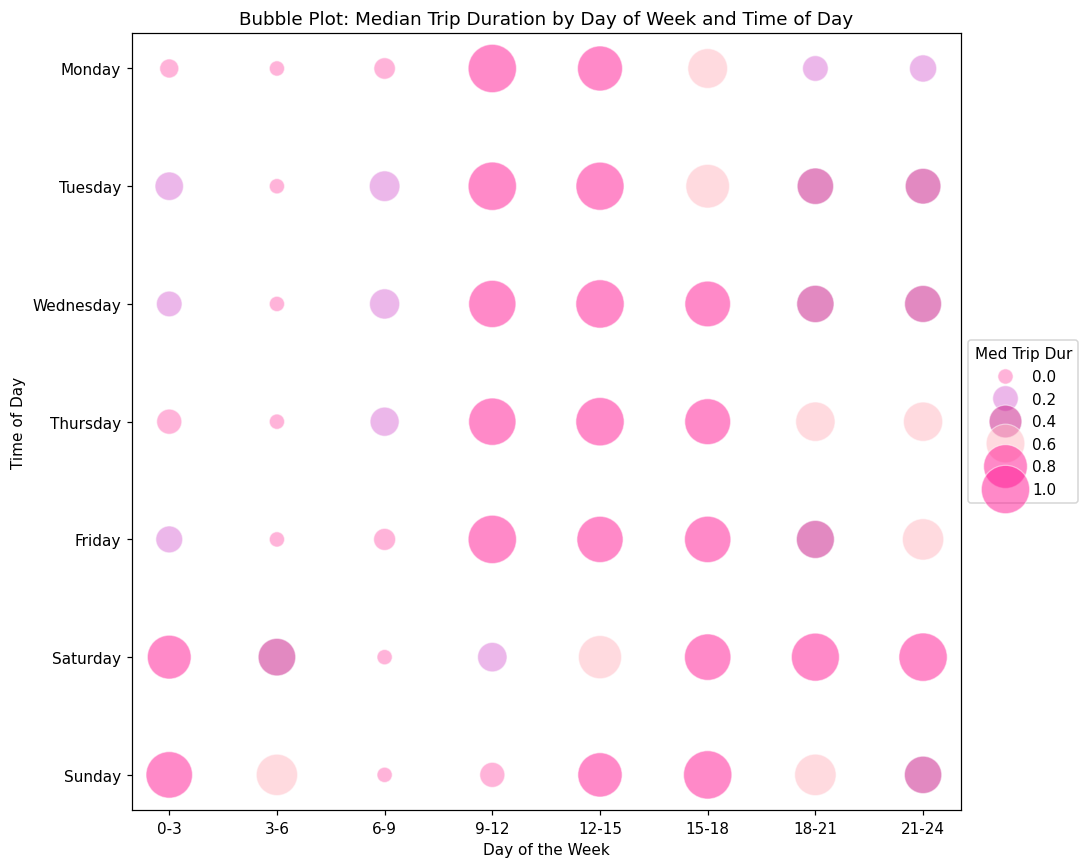

In [51]:
plt.figure(figsize=(10, 8), dpi=110)
scatter = sns.scatterplot(
    y=median_trip_duration["pickup_dayofweek"],
    x=median_trip_duration["pickup_timeofday"],
    size=median_trip_duration["normalized_trip_duration"],
    sizes=(100, 1000),
    hue=median_trip_duration["normalized_trip_duration"],
    palette=BARBIE_COLORMAP,
    alpha=0.5,
)
plt.xlabel("Day of the Week")
plt.ylabel("Time of Day")
plt.title("Bubble Plot: Median Trip Duration by Day of Week and Time of Day")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Med Trip Dur")
plt.tight_layout()
plt.show()

* Another interesting trend emerges - Saturday and Sundays see a similar trip duration accross the day. 
* Whereas weekdays have longer trip duration between 9 am - 6 pm which are typically office hours.
* This in turn could serve as a proxy for traffic/surge hours.

### Distance vs Trip Duration

These two should share the strongest relationship among any variables in this dataset. We'll look at both OSRM's and Haversine's distances and see how they compare.

In [52]:
taxi_train_wo_outliers_df["distance_osrm"] = taxi_train_wo_outliers_df[
    "distance_osrm"
].fillna(taxi_train_wo_outliers_df["distance_haversine"])

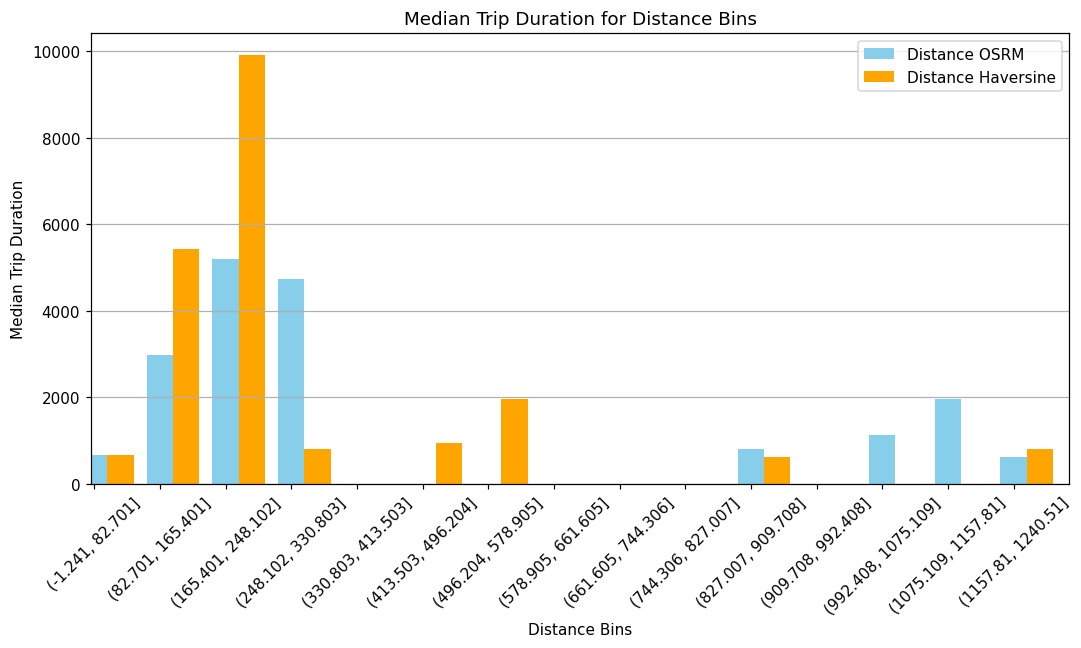

In [53]:
bins_osrm = pd.cut(taxi_train_wo_outliers_df["distance_osrm"], bins=15)
binned_data_median_osrm = taxi_train_wo_outliers_df.groupby(bins_osrm)[
    "trip_duration"
].median()

bins_haversine = pd.cut(taxi_train_wo_outliers_df["distance_haversine"], bins=15)
binned_data_median_haversine = taxi_train_wo_outliers_df.groupby(bins_haversine)[
    "trip_duration"
].median()

fig, ax = plt.subplots(figsize=(10, 6), dpi=110)
binned_data_median_osrm.plot(
    kind="bar", color="skyblue", position=0.5, width=0.4, ax=ax, label="Distance OSRM"
)
binned_data_median_haversine.plot(
    kind="bar",
    color="orange",
    position=-0.5,
    width=0.4,
    ax=ax,
    label="Distance Haversine",
)
plt.title("Median Trip Duration for Distance Bins")
plt.xlabel("Distance Bins")
plt.ylabel("Median Trip Duration")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
plt.show()

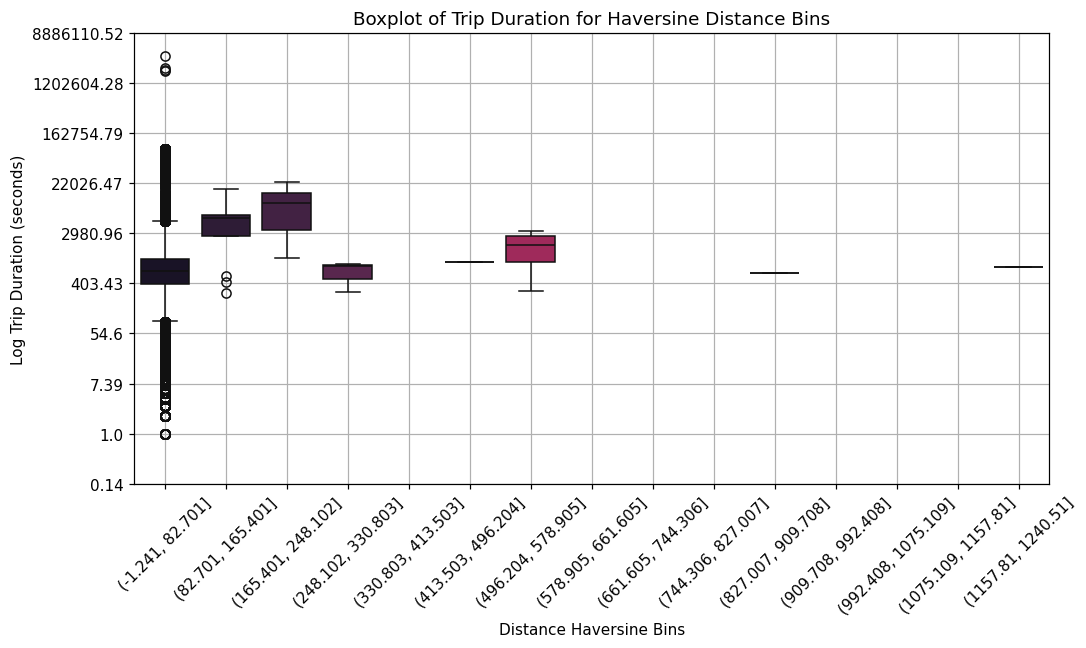

In [54]:
bins = pd.cut(taxi_train_wo_outliers_df["distance_haversine"], bins=15)
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(x=bins, y=taxi_train_wo_outliers_df["log_trip_duration"], palette="rocket")
plt.title("Boxplot of Trip Duration for Haversine Distance Bins")
plt.xlabel("Distance Haversine Bins")
plt.ylabel("Log Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

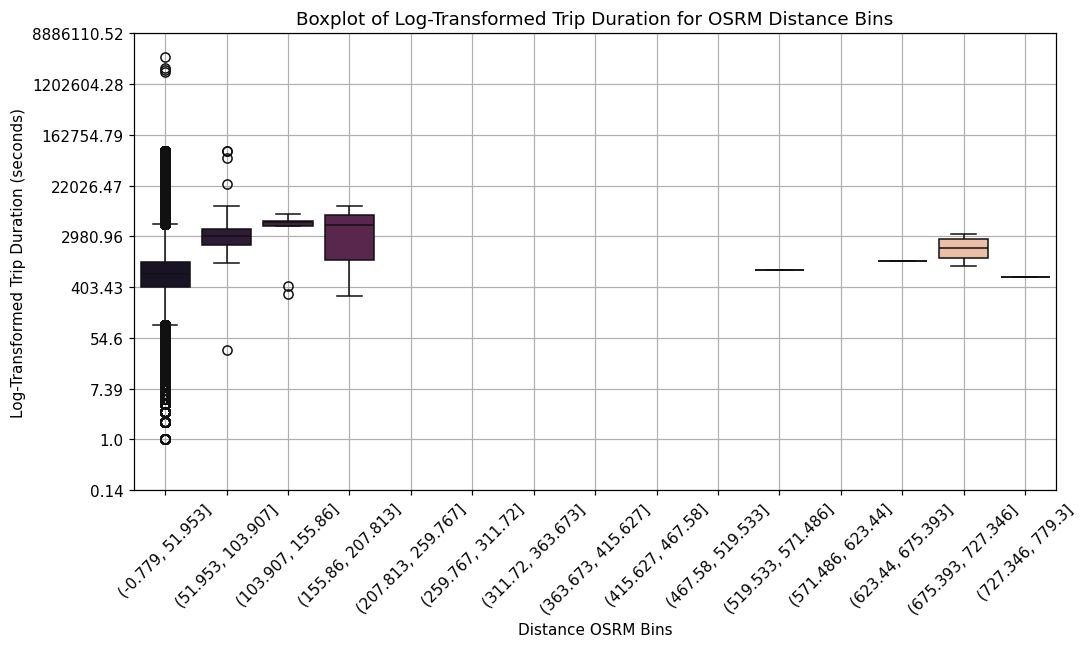

In [55]:
bins = pd.cut(taxi_train_wo_outliers_df["distance_osrm"], bins=15)
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(x=bins, y=taxi_train_wo_outliers_df["log_trip_duration"], palette="rocket")
plt.title("Boxplot of Log-Transformed Trip Duration for OSRM Distance Bins")
plt.xlabel("Distance OSRM Bins")
plt.ylabel("Log-Transformed Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

* We see a weird trend accross both OSRM and Haversine distances.
* Up until a certain distance, the median trip duration keeps increasing and then stagnants and drops.
* This is possibly due to the lack of data for longer trips (Given that New York is a small city).
* This could also be because another latent variable might be impacting the longer trips, such as the lack of traffic.

### Vendor Vs Trip Duration

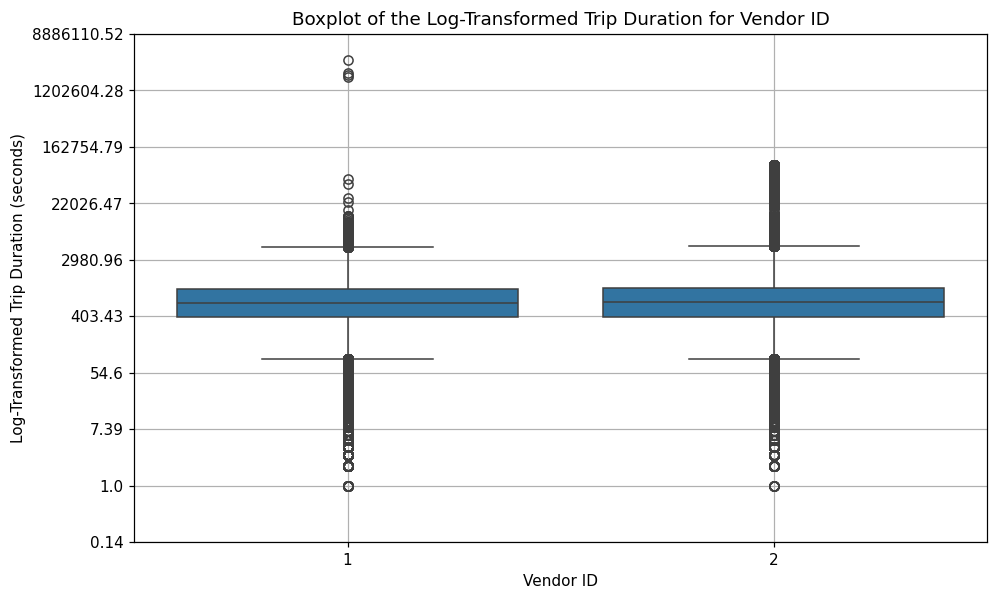

In [56]:
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(
    x="vendor_id",
    y="log_trip_duration",
    data=taxi_train_wo_outliers_df,
)
plt.title("Boxplot of the Log-Transformed Trip Duration for Vendor ID")
plt.xlabel("Vendor ID")
plt.ylabel("Log-Transformed Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.grid()
plt.show()

In [57]:
taxi_train_wo_outliers_df.groupby(["vendor_id"])["trip_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
vendor_id,,,,,,,,
1,676303.0,845.665889,6157.102681,1.0,395.0,658.0,1068.0,3526282.0
2,777310.0,1058.634789,4286.364019,1.0,399.0,666.0,1083.0,86392.0


There is little to no difference between the median trip duration among vendors.

### Store and Forward Flag Vs Trip Duration

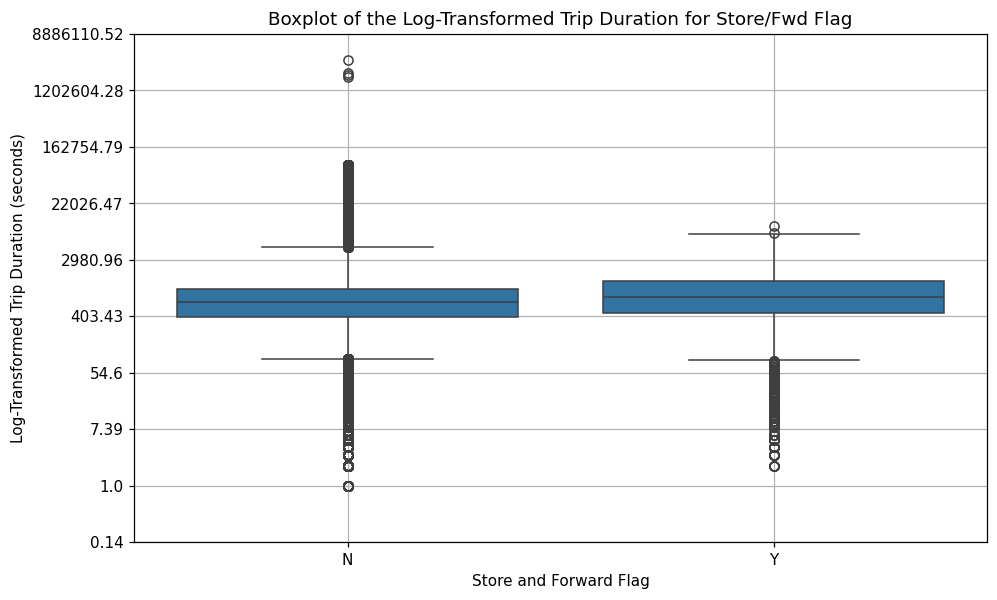

In [58]:
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(
    x="store_and_fwd_flag",
    y="log_trip_duration",
    data=taxi_train_wo_outliers_df,
)
plt.title("Boxplot of the Log-Transformed Trip Duration for Store/Fwd Flag")
plt.xlabel("Store and Forward Flag")
plt.ylabel("Log-Transformed Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.grid()
plt.show()

In [59]:
taxi_train_wo_outliers_df.groupby(["store_and_fwd_flag"])["trip_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
store_and_fwd_flag,,,,,,,,
N,1445588.0,958.871147,5255.622427,1.0,397.0,662.0,1074.0,3526282.0
Y,8025.0,1081.764735,926.486721,2.0,456.0,813.0,1402.0,9984.0


The Yes flag sees a much higher median trip duration -- perhaps these could be prebooked cabs?

### Passenger Count vs Trip Duration

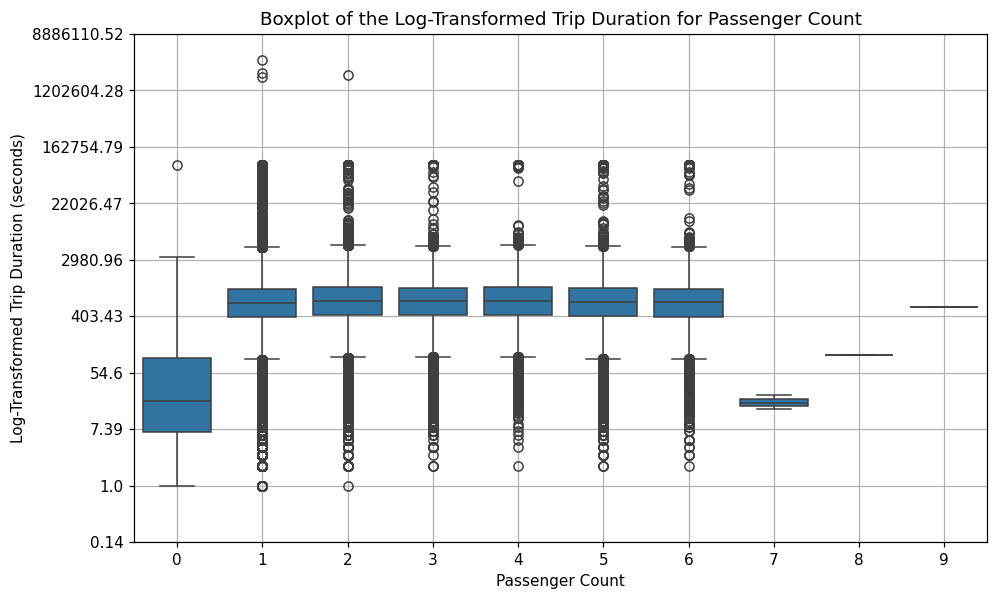

In [60]:
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(
    x="passenger_count",
    y="log_trip_duration",
    data=taxi_train_wo_outliers_df,
)
plt.title("Boxplot of the Log-Transformed Trip Duration for Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Log-Transformed Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.grid()
plt.show()

In [61]:
taxi_train_wo_outliers_df.groupby(["passenger_count"])["trip_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
passenger_count,,,,,,,,
0,60.0,1718.433333,11072.157098,1.0,6.75,20.5,92.25,85901.0
1,1030090.0,930.517953,5392.249600,1.0,391.00,654.0,1062.00,3526282.0
2,209547.0,1005.880948,5503.479545,1.0,416.00,689.0,1122.00,2049578.0
3,59690.0,1027.677165,3708.718136,2.0,418.00,688.0,1111.00,86365.0
4,28300.0,1054.694735,3796.450365,2.0,423.00,698.0,1136.00,86379.0
5,77776.0,1069.184761,4366.892844,2.0,401.00,670.0,1088.00,86378.0
6,48145.0,1060.682501,4361.411833,2.0,398.00,663.0,1076.00,86377.0
7,3.0,19.666667,5.033223,15.0,17.00,19.0,22.00,25.0
8,1.0,104.000000,NaN,104.0,104.00,104.0,104.00,104.0


* Passenger count is making some difference to the median trip duration but not by a significant amount.
* The only differences we're seeing is between 0 and 1.
* We could bucketize it as follows:
    - 0
    - 1-3
    - 4-6
    - 7-9

In [62]:
taxi_train_wo_outliers_df["passenger_count_bucket"] = pd.cut(
    taxi_train_wo_outliers_df["passenger_count"],
    bins=PASSENGER_BIN_EDGES,
    labels=PASSENGER_BUCKETS,
)

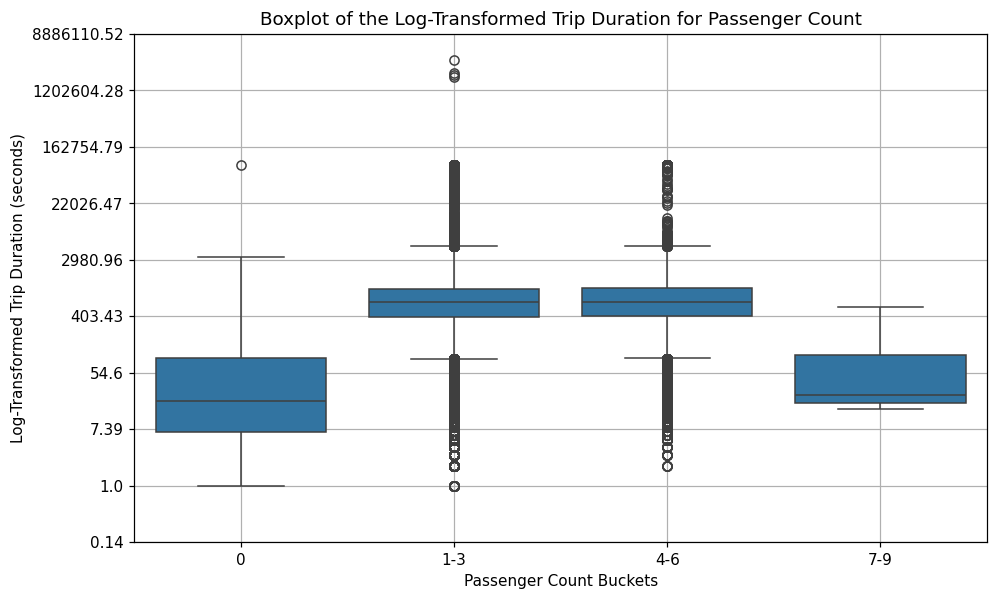

In [63]:
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(
    x="passenger_count_bucket",
    y="log_trip_duration",
    data=taxi_train_wo_outliers_df,
    order=PASSENGER_BUCKETS,
)
plt.title("Boxplot of the Log-Transformed Trip Duration for Passenger Count")
plt.xlabel("Passenger Count Buckets")
plt.ylabel("Log-Transformed Trip Duration (seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.grid()
plt.show()

In [64]:
taxi_train_wo_outliers_df.groupby(["passenger_count_bucket"])["trip_duration"].describe()

,count,mean,std,min,25%,50%,75%,max
passenger_count_bucket,,,,,,,,
0,60.0,1718.433333,11072.157098,1.0,6.75,20.5,92.25,85901.0
1-3,1299327.0,947.135419,5344.995622,1.0,396.00,661.0,1074.00,3526282.0
4-6,154221.0,1063.871548,4266.158411,2.0,404.00,673.0,1094.00,86379.0
7-9,5.0,144.600000,235.096363,15.0,19.00,25.0,104.00,560.0


### Correlation Plot

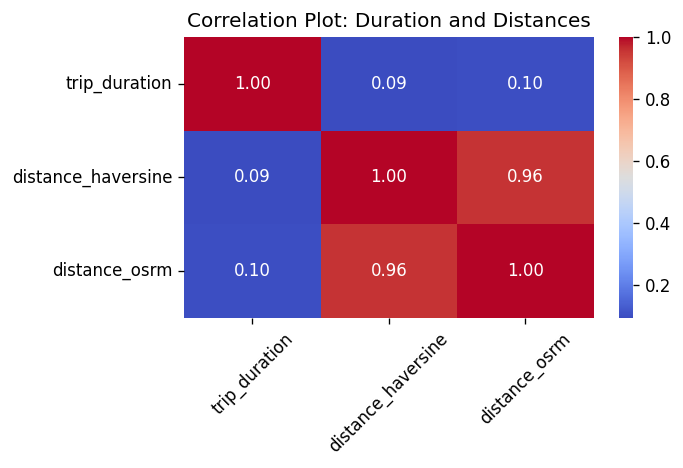

In [65]:
correlation_matrix = taxi_train_wo_outliers_df[
    ["trip_duration", "distance_haversine", "distance_osrm"]
].corr()
plt.figure(figsize=(6, 4), dpi=120)
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.title("Correlation Plot: Duration and Distances")
plt.tight_layout()
plt.show()

Ironically, although distance and duration should share a strong positive correlation, it's very weak.

## Multivariate Analysis

Do certain variables work in synergy with one another?

### Vendor ID vs Passenger Count

* Let's start with passenger count.
* Perhaps a certain vendor captures the flag more often? Let's find out:

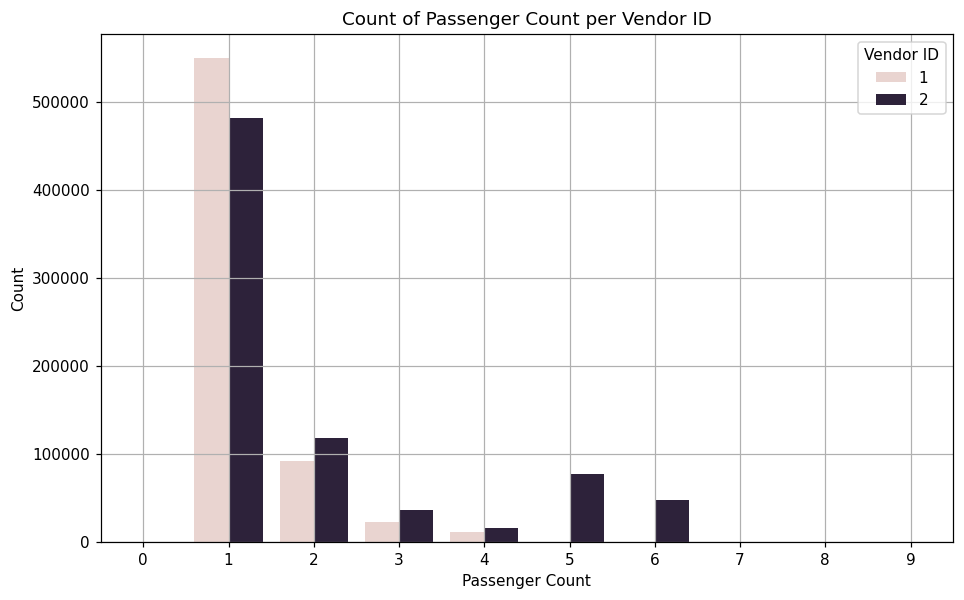

In [66]:
plt.figure(figsize=(10, 6), dpi=110)
sns.countplot(data=taxi_train_wo_outliers_df, x="passenger_count", hue="vendor_id")
plt.title("Count of Passenger Count per Vendor ID")
plt.xlabel("Passenger Count")
plt.ylabel("Count")
plt.legend(title="Vendor ID")
plt.grid()
plt.show()

* There doesn't seem to be a significant differnce among the two for rides with fewer passengers.
* However, vendor 2 does seem to be taking rides with more passengers (> 5 per pickup).

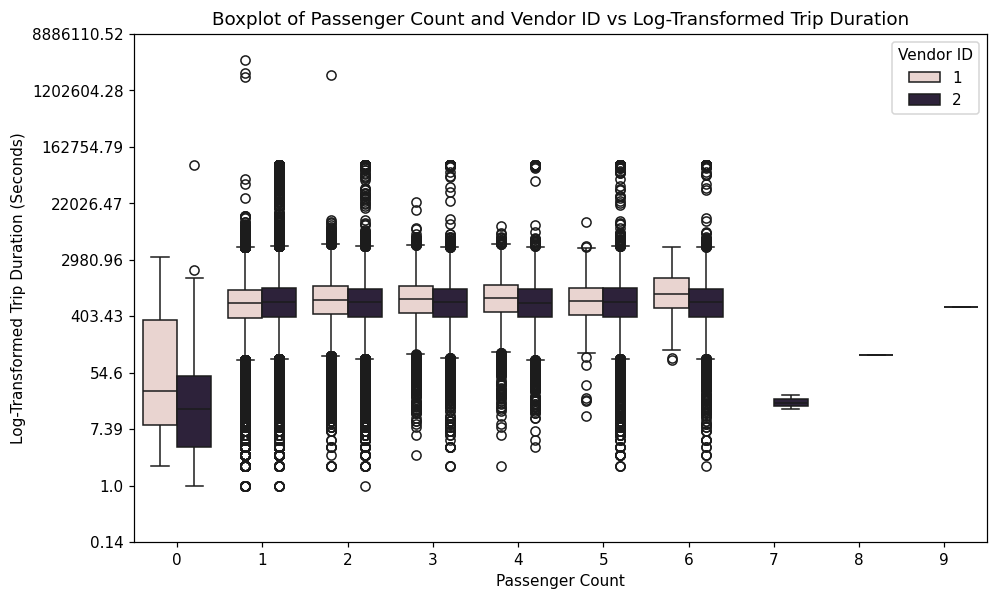

In [67]:
plt.figure(figsize=(10, 6), dpi=110)
sns.boxplot(
    data=taxi_train_wo_outliers_df,
    x="passenger_count",
    y="log_trip_duration",
    hue="vendor_id",
)
plt.title("Boxplot of Passenger Count and Vendor ID vs Log-Transformed Trip Duration")
plt.xlabel("Passenger Count")
plt.ylabel("Log-Transformed Trip Duration (Seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.legend(title="Vendor ID")
plt.show()

* From the looks of it, vendor 1 seems to take longer trips when comparing their medians.
* Perhaps vendor 2 consists primarily of larger vehicles that family use for recreational trips.
* Vendor 1 might be office vehicles people use to commute within the city.
* Let's verify this by comparing the day of the week, vendor type and trip duration.

In [68]:
average_pickups_per_day = (
    (
        taxi_train_wo_outliers_df.groupby(["pickup_dayofweek", "vendor_id"])[
            "id"
        ].nunique()
        / taxi_train_wo_outliers_df.groupby(["pickup_dayofweek", "vendor_id"])[
            "pickup_date"
        ].nunique()
    )
    .reset_index()
    .rename(columns={0: "avg_pickups_per_day"})
)

average_pickups_per_day = (
    average_pickups_per_day.set_index("pickup_dayofweek").loc[DAY_NAMES].reset_index()
)

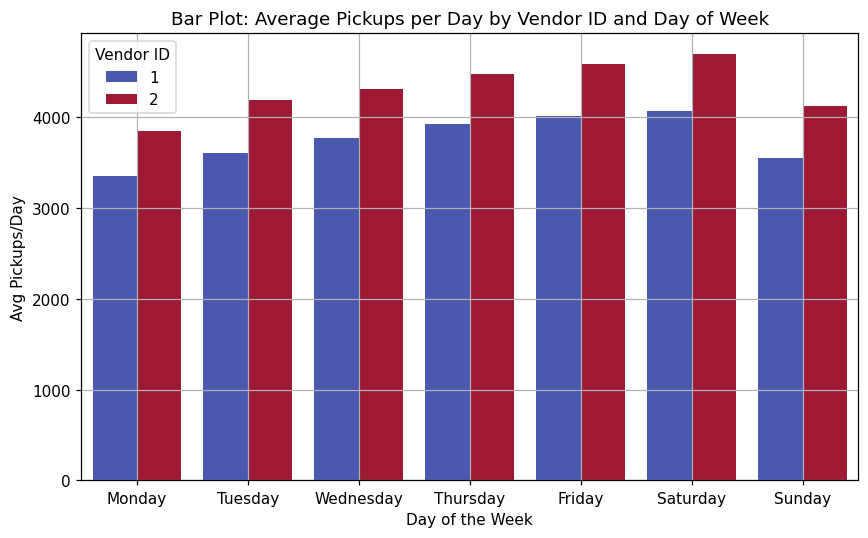

In [69]:
plt.figure(figsize=(8, 5), dpi=110)
sns.barplot(
    x="pickup_dayofweek",
    y="avg_pickups_per_day",
    hue="vendor_id",
    data=average_pickups_per_day,
    palette="coolwarm",
)

plt.xlabel("Day of the Week")
plt.ylabel("Avg Pickups/Day")
plt.title("Bar Plot: Average Pickups per Day by Vendor ID and Day of Week")
plt.legend(title="Vendor ID")
plt.grid()
plt.tight_layout()
plt.show()

Since there is no difference among the trends of each vendor ID, we can't make such a claim. However, we know there's a difference in trip duration among various vendor IDs and counts of passengers.

### Store and Forward Flag vs Passenger Count

We're going to perform the same analysis on the store and forward flag as we did with vendor ID.

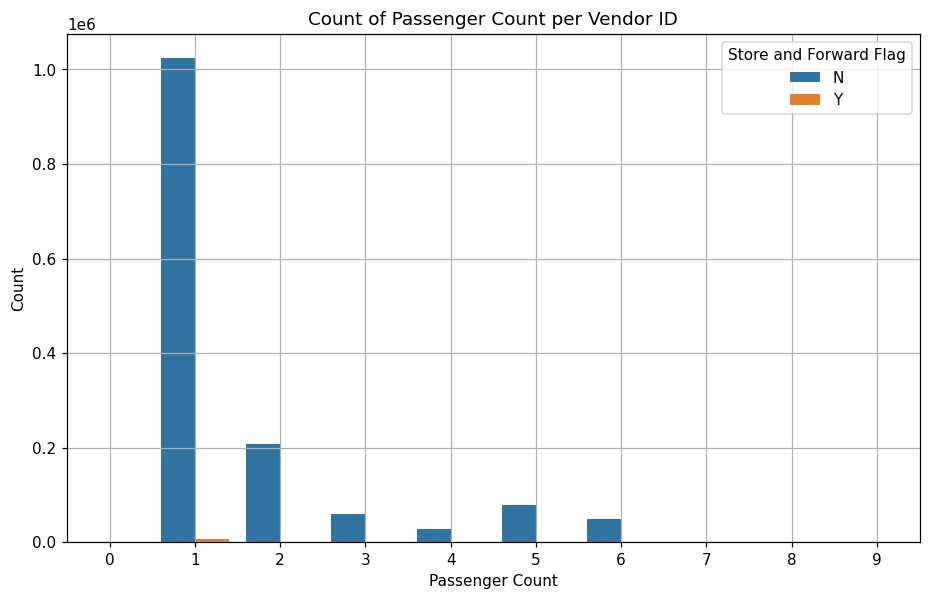

In [70]:
plt.figure(figsize=(10, 6), dpi=110)
sns.countplot(
    data=taxi_train_wo_outliers_df, x="passenger_count", hue="store_and_fwd_flag"
)
plt.title("Count of Passenger Count per Vendor ID")
plt.xlabel("Passenger Count")
plt.ylabel("Count")
plt.legend(title="Store and Forward Flag")
plt.grid()
plt.show()

* Because most of the flags are marked as No, it's difficult to see any trend.
* Let's plot them on two separate subplots and see what they look like:

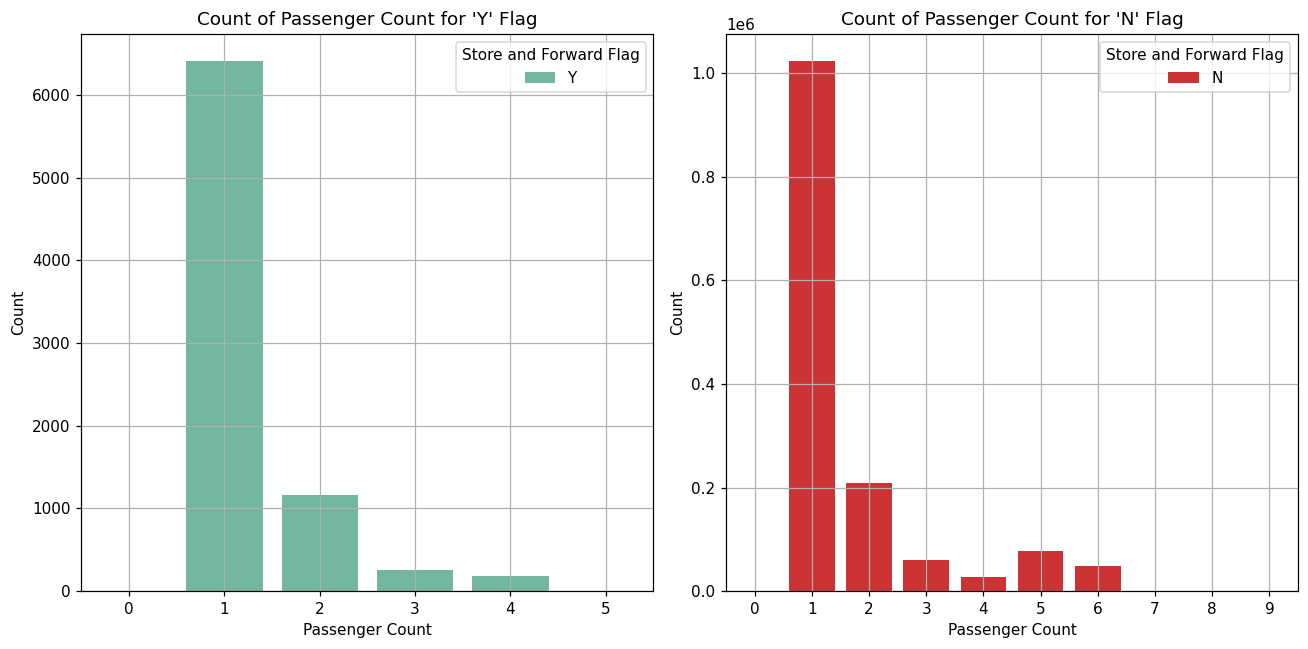

In [71]:
plt.figure(figsize=(12, 6), dpi=110)

# Subplot for 'Y' flag with a specific color palette
plt.subplot(1, 2, 1)
sns.countplot(
    data=taxi_train_wo_outliers_df[
        taxi_train_wo_outliers_df["store_and_fwd_flag"] == "Y"
    ],
    x="passenger_count",
    hue="store_and_fwd_flag",
    palette="Set2",
)
plt.title("Count of Passenger Count for 'Y' Flag")
plt.xlabel("Passenger Count")
plt.ylabel("Count")
plt.legend(title="Store and Forward Flag")
plt.grid()

# Subplot for 'N' flag with a different color palette
plt.subplot(1, 2, 2)
sns.countplot(
    data=taxi_train_wo_outliers_df[
        taxi_train_wo_outliers_df["store_and_fwd_flag"] == "N"
    ],
    x="passenger_count",
    hue="store_and_fwd_flag",
    palette="Set1",
)
plt.title("Count of Passenger Count for 'N' Flag")
plt.xlabel("Passenger Count")
plt.ylabel("Count")
plt.legend(title="Store and Forward Flag")
plt.grid()

plt.tight_layout()
plt.show()

* There is some trend, but it's barely discernable due to the imbalance in the distributions among the two variables.
* Now let's look at trip durations.

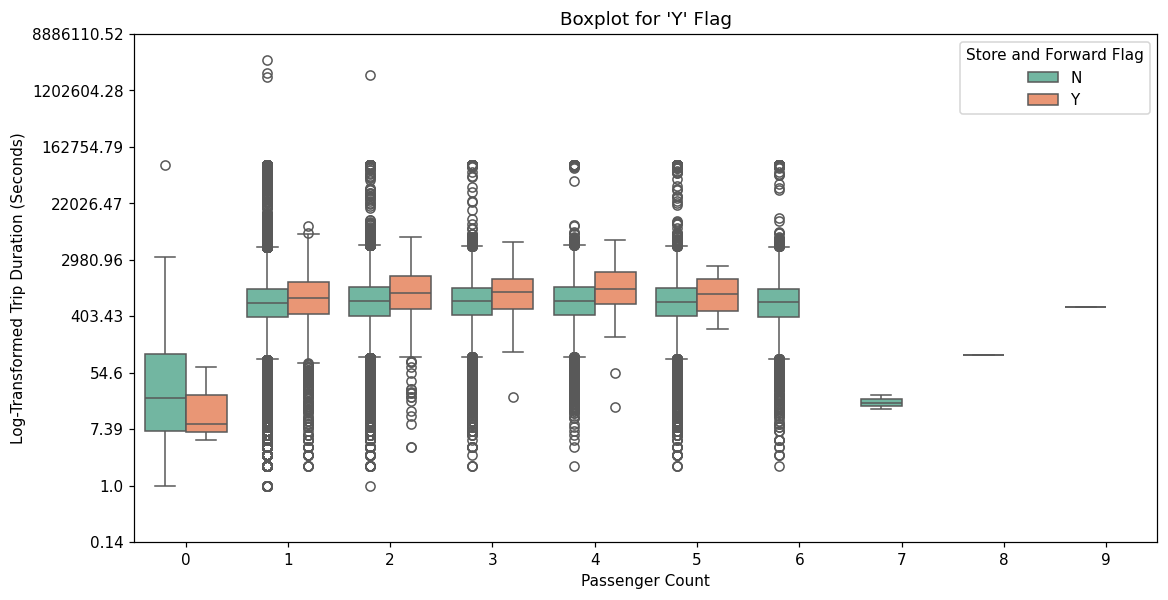

In [72]:
plt.figure(figsize=(12, 6), dpi=110)
sns.boxplot(
    data=taxi_train_wo_outliers_df,
    x="passenger_count",
    y="log_trip_duration",
    hue="store_and_fwd_flag",
    palette="Set2",
)
plt.title("Boxplot for 'Y' Flag")
plt.xlabel("Passenger Count")
plt.ylabel("Log-Transformed Trip Duration (Seconds)")
ticks, _ = plt.yticks()
tick_labels = [round(np.exp(y), 2) for y in ticks]
plt.yticks(ticks, tick_labels)
plt.legend(title="Store and Forward Flag")

* We're seeing some difference among the store and forward flag and passenger counts.
* The Yes flag typically has longer trips when comparing medians and including the passenger counts

Now let's model this data.